# 1. Expectation:

#### Questions

- Is there any coorelation among the data?
    
    Yes, JCS, SIZE_LCS, WORD_COUNT_DIFF
    
- What are the correlations are?

    JCS is propertional to SIZE_LCS
    
    JCS is inverse propertional to WORD_COUNT_DIFF
    
  
  
- How are the data distributed?
    
    
- What should be the cut-off parameters?


 
#### Revised Expectation:

#### Conclution:



In [3]:
%%time
#!conda remove -y seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/mxnet_p36

  removed specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_1         157 KB

The following packages will be REMOVED:

    seaborn: 0.8.1-py36hfad7ec4_0

The following packages will be UPDATED:

    certifi: 2019.11.28-py36_0    --> 2019.11.28-py36_1


certifi-2019.11.28   | 157 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
CPU times: user 644 ms, sys: 168 ms, total: 812 ms
Wall time: 51.6 s


In [1]:
%%time
#!conda install -y seaborn=0.9.0

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [2]:
%%time
import seaborn as sns
print(sns.__version__)

0.9.0
CPU times: user 2.94 s, sys: 2.56 s, total: 5.5 s
Wall time: 562 ms


In [3]:
import os
import boto3
import difflib
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import stats

from bs4 import BeautifulSoup
from datetime import date, timedelta

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()
    
spark

In [19]:
from pyspark.sql.types import  LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType, DoubleType, DateType, TimestampType
from pyspark.sql.functions import lit, udf, col, broadcast, datediff, to_date, desc, asc, regexp_replace, size, from_json
from pyspark.ml.feature import Tokenizer, RegexTokenizer, MinHashLSH, CountVectorizer, NGram

In [5]:
import s3fs

# Input: 'pr-insights-hits-production/PR-Impact/Output'
def get_all_files_of_output_path(path):

    fs = s3fs.S3FileSystem()
    # To List 5 files in your accessible bucket
    date_list = fs.ls(path)[:]

    master_timestamp_list =[]
    total_files = 0
    for timestamp_list in date_list:
        these_files = len(fs.ls(timestamp_list))
        # print(these_files)
        total_files += these_files
        master_timestamp_list = master_timestamp_list + fs.ls(timestamp_list)

    print(f"Total files {total_files}")
    all_files_list = ["s3a://" + f for f in master_timestamp_list] 
    return all_files_list


# Input: 'pr-insights-hits-production/PR-Impact/Output/20200221'
def get_files_of_a_day(day_path):
    fs = s3fs.S3FileSystem()
    
    # To List files in your accessible bucket
    try:
        timestamp_list = fs.ls(day_path)[:]    
        print(f"Total files of the day {day_path[-8:]} : {len(timestamp_list)}  (URL: {day_path})")
        daily_files_list = ["s3a://" + f for f in timestamp_list] 
        return daily_files_list
    
    except FileNotFoundError:
        print("Url not Found")
        return []
        
    


def get_files_of_a_date_range(suburl, d1, d2):

    # d1 = date(2020,3,1)
    # d2 = date(2020,3,20)
    # suburl = 'pr-insights-hits-production/PR-Impact/Output/' 
    master_timestamp_list =[]

    # this will give you a list containing all of the dates
    dd = [d1 + timedelta(days=x) for x in range((d2-d1).days + 1)]
    for d in dd:

        # Create url
        url = suburl + d.strftime("%Y%m%d")
        # print(f"Url in date range: {url}")

        # Get file list
        day_files = get_files_of_a_day(url)
        # print(len(day_files))
        master_timestamp_list = master_timestamp_list + day_files


    print(f"Total files in date range {d1.strftime('%Y%m%d')} to {d2.strftime('%Y%m%d')} : {len(master_timestamp_list)}")

    return master_timestamp_list


### Call functions to get a chunck of data by date range

In [6]:
# get_files_of_a_day('pr-insights-hits-production/PR-Impact/Output/20200301')

# all_files = get_all_files_of_output_path('pr-insights-hits-production/PR-Impact/Output')
# print("The last file:")
# all_files[-2:]

range_files = get_files_of_a_date_range('pr-insights-hits-production/PR-Impact/Output/', date(2020,3,1), date(2020,3,31))
print("Some last files:")
range_files[-2:]



Total files of the day 20200301 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200301)
Total files of the day 20200302 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200302)
Total files of the day 20200303 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200303)
Total files of the day 20200304 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200304)
Total files of the day 20200305 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200305)
Total files of the day 20200306 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200306)
Total files of the day 20200307 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200307)
Total files of the day 20200308 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200308)
Total files of the day 20200309 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200309)
Total files of the day 20200310 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200310)
Total file

['s3a://pr-insights-hits-production/PR-Impact/Output/20200331/20200331T230000',
 's3a://pr-insights-hits-production/PR-Impact/Output/20200331/20200331T233000']

In [7]:

final_output_location = get_files_of_a_date_range('pr-insights-hits-production/PR-Impact/Output/', date(2020,3,1), date(2020,3,31))

#                        [
#                        "s3a://pr-insights-hits-production/PR-Impact/Output/20200221/20200221T080000",
#                         "s3a://pr-insights-hits-production/PR-Impact/Output/20200221/20200221T083000",
#                         ]

# "s3a://mnd-spark-test/sg/test/output/" + _EXECUTION_DATE + "/" + _EXECUTION_TIME + "/"

Total files of the day 20200301 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200301)
Total files of the day 20200302 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200302)
Total files of the day 20200303 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200303)
Total files of the day 20200304 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200304)
Total files of the day 20200305 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200305)
Total files of the day 20200306 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200306)
Total files of the day 20200307 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200307)
Total files of the day 20200308 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200308)
Total files of the day 20200309 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200309)
Total files of the day 20200310 : 47  (URL: pr-insights-hits-production/PR-Impact/Output/20200310)
Total file

In [8]:
result_df = spark.read.option("compression", "gzip").json(final_output_location, multiLine=False)
# result_df.show()
result_df.count()

416351

In [9]:
result_df.createOrReplaceTempView("matchings")

In [10]:
result_df.printSchema()

root
 |-- ARTICLE_ID: long (nullable = true)
 |-- ARTICLE_PUBLISH_DATE: string (nullable = true)
 |-- ARTICLE_SOURCE: string (nullable = true)
 |-- ARTICLE_TEXT: string (nullable = true)
 |-- ARTICLE_URL: string (nullable = true)
 |-- CONTENT_ID: long (nullable = true)
 |-- CONTENT_PUBLISH_DATE: string (nullable = true)
 |-- CONTENT_TEXT: string (nullable = true)
 |-- CONTENT_TYPE: string (nullable = true)
 |-- JCS: double (nullable = true)
 |-- LCS: string (nullable = true)
 |-- SIZE_LCS: string (nullable = true)
 |-- WORD_COUNT_DIFF: long (nullable = true)



## Descriptive analysis
### Check the overall distribution of the figures

In [15]:
initial_df = spark.sql("SELECT CONTENT_ID, JCS, SIZE_LCS, WORD_COUNT_DIFF, length(CONTENT_TEXT), length(ARTICLE_TEXT), ARTICLE_SOURCE, CONTENT_TYPE FROM matchings")
initial_df.show()

+----------+-------------------+--------+---------------+--------------------+--------------------+--------------------+-------------+
|CONTENT_ID|                JCS|SIZE_LCS|WORD_COUNT_DIFF|length(CONTENT_TEXT)|length(ARTICLE_TEXT)|      ARTICLE_SOURCE| CONTENT_TYPE|
+----------+-------------------+--------+---------------+--------------------+--------------------+--------------------+-------------+
|   2965254| 0.9846153846153847|     33 |              1|                 676|                 649|{"id":47331,"name...|pressreleases|
|   2986013| 0.6927083333333334|     65 |            119|                2287|                1408|{"id":19961,"name...|pressreleases|
|   2986091| 0.6923076923076923|     29 |           -178|                 483|                1669|{"id":47331,"name...|pressreleases|
|   2981413|  0.611764705882353|     42 |            439|                4998|                2302|{"id":2468,"name"...|pressreleases|
|   2986160|0.25531914893617014|     20 |            42

### Source analysis

In [14]:
initial_df.select('ARTICLE_SOURCE').take(10)

[Row(ARTICLE_SOURCE='{"id":47331,"name":"KYLA+","language":"sv","country":"SE","type":"Media"}'),
 Row(ARTICLE_SOURCE='{"id":19961,"name":"Trelleborgs Allehanda","language":"sv","country":"SE","type":"Media"}'),
 Row(ARTICLE_SOURCE='{"id":47331,"name":"KYLA+","language":"sv","country":"SE","type":"Media"}'),
 Row(ARTICLE_SOURCE='{"id":2468,"name":"Jordbruks Aktuellt","language":"sv","country":"SE","type":"Media"}'),
 Row(ARTICLE_SOURCE='{"id":1524,"name":"Resumé","language":"sv","country":"SE","type":"Media"}'),
 Row(ARTICLE_SOURCE='{"id":7868,"name":"Cision SE","language":"sv","country":"SE","type":"Media"}'),
 Row(ARTICLE_SOURCE='{"id":6433,"name":"Västerås Tidning","language":"sv","country":"SE","type":"Media"}'),
 Row(ARTICLE_SOURCE='{"id":47331,"name":"KYLA+","language":"sv","country":"SE","type":"Media"}'),
 Row(ARTICLE_SOURCE='{"id":6433,"name":"Västerås Tidning","language":"sv","country":"SE","type":"Media"}'),
 Row(ARTICLE_SOURCE='{"id":46837,"name":"Bilfeber","language":"sv",

In [17]:
schema = StructType([StructField("id", IntegerType()), 
                     StructField("name", StringType()),
                     StructField("language", StringType()),
                     StructField("country", StringType()),
                     StructField("type", StringType())])

In [22]:
initial_df_2 = initial_df.withColumn("ARTICLE_SOURCE_2", from_json(initial_df.ARTICLE_SOURCE, schema))
initial_df_2.select("ARTICLE_SOURCE", "ARTICLE_SOURCE_2").show(5, False)

+-----------------------------------------------------------------------------------------+---------------------------------------------+
|ARTICLE_SOURCE                                                                           |ARTICLE_SOURCE_2                             |
+-----------------------------------------------------------------------------------------+---------------------------------------------+
|{"id":47331,"name":"KYLA+","language":"sv","country":"SE","type":"Media"}                |[47331, KYLA+, sv, SE, Media]                |
|{"id":19961,"name":"Trelleborgs Allehanda","language":"sv","country":"SE","type":"Media"}|[19961, Trelleborgs Allehanda, sv, SE, Media]|
|{"id":47331,"name":"KYLA+","language":"sv","country":"SE","type":"Media"}                |[47331, KYLA+, sv, SE, Media]                |
|{"id":2468,"name":"Jordbruks Aktuellt","language":"sv","country":"SE","type":"Media"}    |[2468, Jordbruks Aktuellt, sv, SE, Media]    |
|{"id":1524,"name":"Resumé","langu

## Descriptive analysis
### Check the distinct count of PRs

In [11]:
count_cont_df = spark.sql("SELECT CONTENT_ID, count(CONTENT_ID) COUNT, avg(JCS) as AVG_JC, max(JCS) as MAX_JC, avg(SIZE_LCS) AVG_LC, max(SIZE_LCS) as MAX_LC FROM matchings \
                          GROUP BY CONTENT_ID \
                          ORDER BY COUNT DESC")

count_cont_df.show()
count_cont_df.count()

+----------+-----+--------------------+-------------------+------------------+------+
|CONTENT_ID|COUNT|              AVG_JC|             MAX_JC|            AVG_LC|MAX_LC|
+----------+-----+--------------------+-------------------+------------------+------+
|    395292| 1220|0.015243036411146518|0.06666666666666665| 5.188524590163935|    8 |
|   2980468|  994| 0.01828079235589908| 0.6111111111111112| 5.962776659959759|    9 |
|   2981973|  916|0.013124343113308944|0.05102040816326525| 5.306768558951965|    9 |
|   2977231|  827| 0.06253531246094696| 0.4883720930232558|12.361547762998791|    9 |
|   2979613|  793|0.016178912004810125| 0.3116883116883117|  5.62547288776797|    9 |
|   2979823|  775|0.016188690403218048| 0.5923076923076923| 6.512258064516129|    9 |
|    395186|  756|0.023119598372584045|0.05882352941176472| 5.906084656084656|    6 |
|   2979547|  740| 0.04475179430071555| 0.6783216783216783| 11.06891891891892|    9 |
|   2981473|  737|0.019955534558224814| 0.967455621301

8305

In [12]:
pr_count_pdf = count_cont_df.toPandas()

pr_count_pdf["MAX_LC"] = pd.to_numeric(pr_count_pdf["MAX_LC"])
pr_count_pdf.head()

,CONTENT_ID,COUNT,AVG_JC,MAX_JC,AVG_LC,MAX_LC
0,395292,1220,0.015243,0.066667,5.188525,8
1,2980468,994,0.018281,0.611111,5.962777,9
2,2981973,916,0.013124,0.051020,5.306769,9
3,2977231,827,0.062535,0.488372,12.361548,9
4,2979613,793,0.016179,0.311688,5.625473,9


## Exploratory analysis (Find hypothsis)


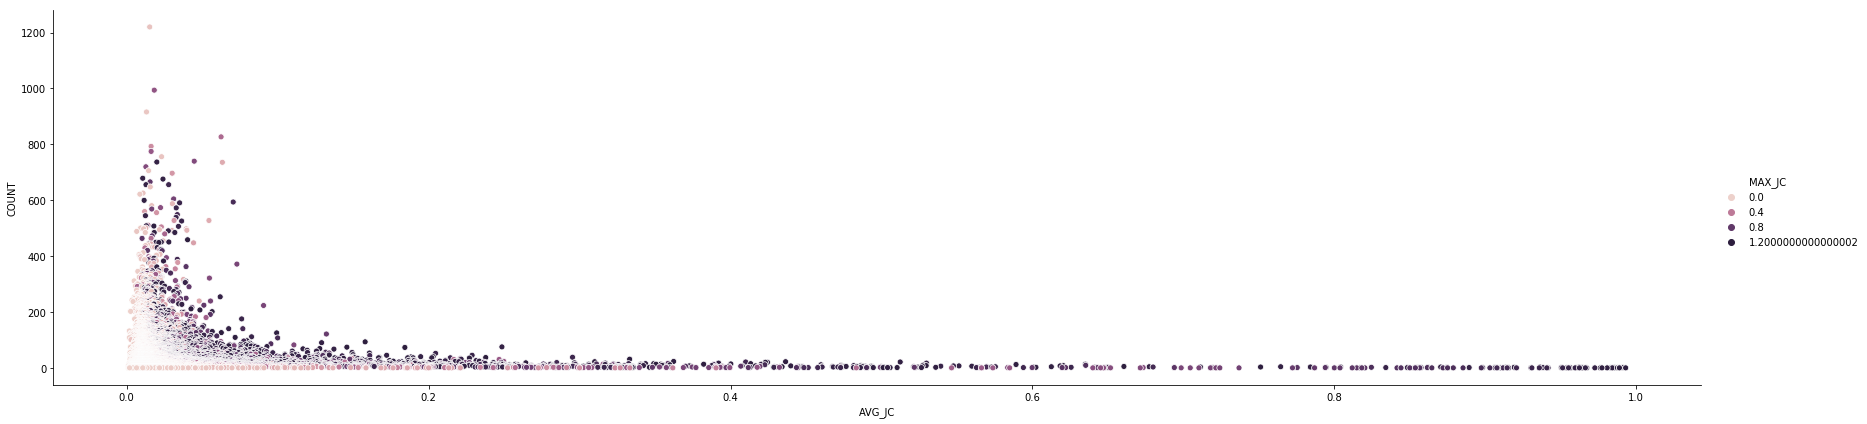

In [13]:
sns.relplot(x="AVG_JC", y="COUNT", hue="MAX_JC", data=pr_count_pdf, height=6, aspect=4);

- Where the PR count is small AVG_JC and MAX_JC should be near same value. 
- Where the COUNT is high and the AVG_JC is high - those are popular documents


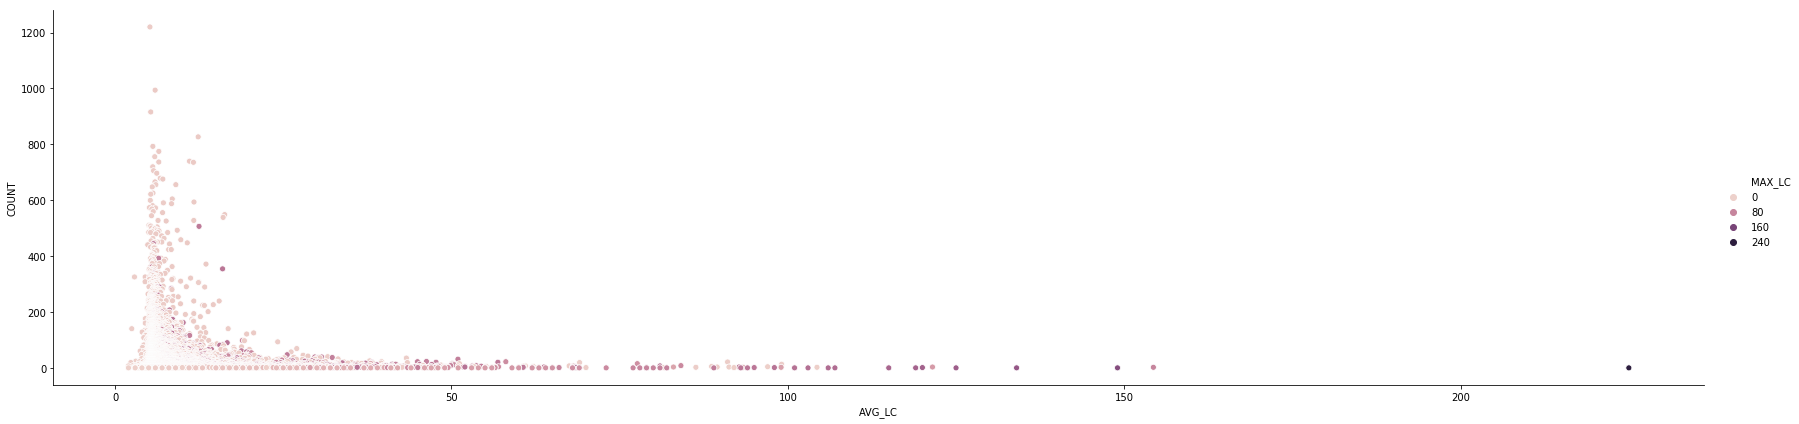

In [14]:
sns.relplot(x="AVG_LC", y="COUNT", hue="MAX_LC", data=pr_count_pdf, height=6, aspect=4);

- Where the PR count is small AVG_LC and MAX_LC should be near same value. 

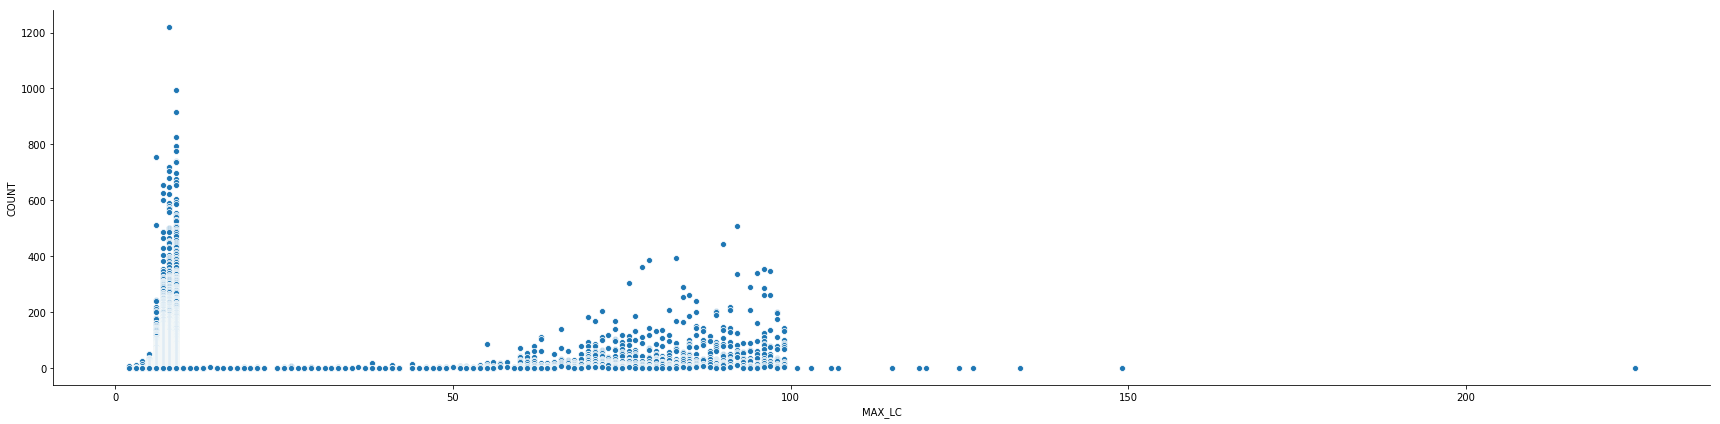

In [15]:
sns.relplot(x="MAX_LC", y="COUNT", data=pr_count_pdf, height=6, aspect=4);


 - A boundary is visible when MAX_LC in around 20
 

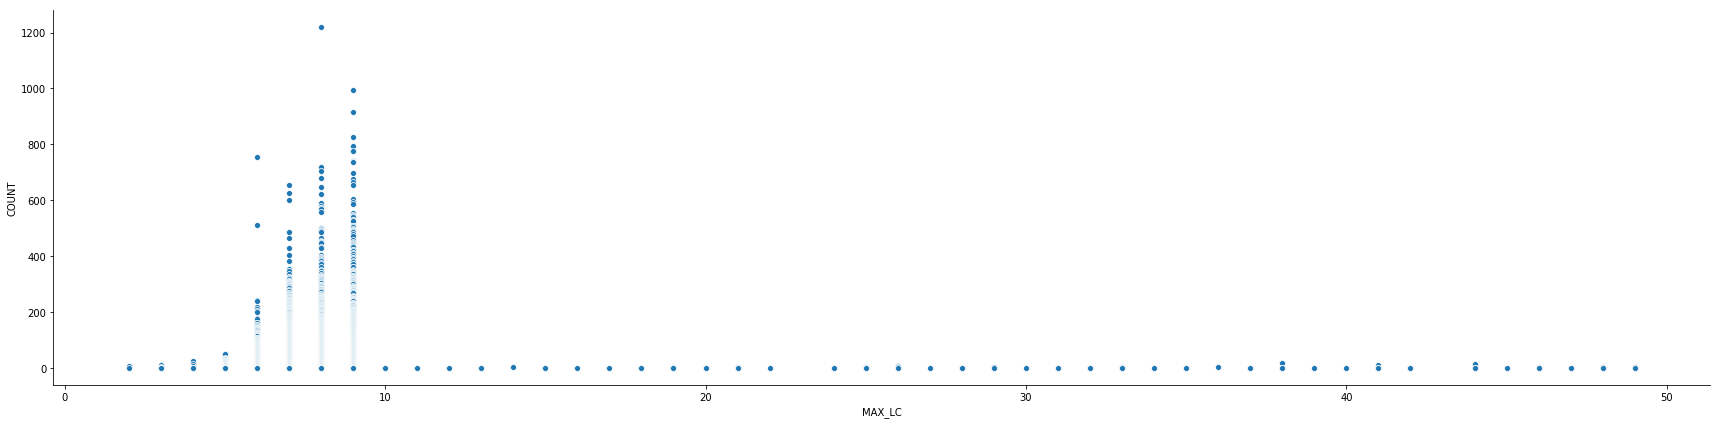

In [16]:
sns.relplot(x="MAX_LC", y="COUNT", data=pr_count_pdf[pr_count_pdf["MAX_LC"]<50], height=6, aspect=4);


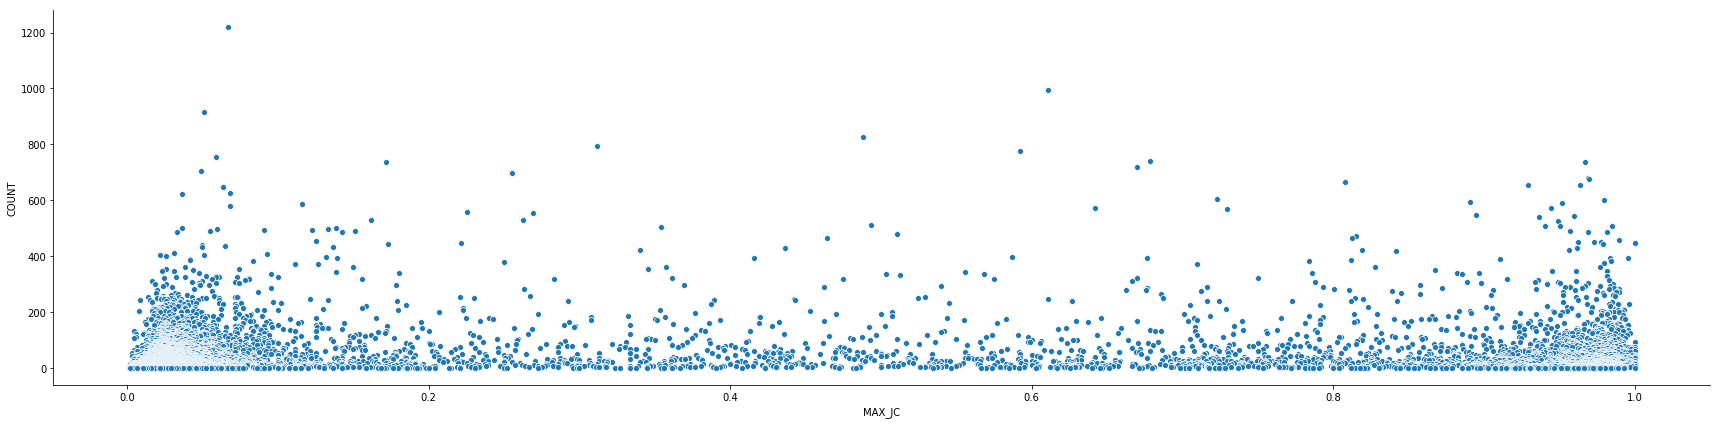

In [17]:
sns.relplot(x="MAX_JC", y="COUNT", data=pr_count_pdf, height=6, aspect=4);

 - A boundary is visible when MAX_JC ~ 0.2

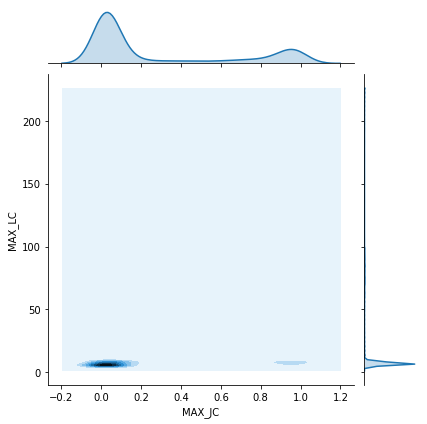

In [18]:
sns.jointplot(x="MAX_JC", y="MAX_LC", data=pr_count_pdf, kind="kde");

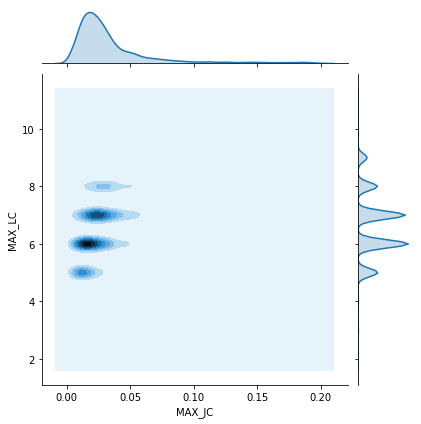

In [19]:
sns.jointplot(x="MAX_JC", y="MAX_LC", data=pr_count_pdf[(pr_count_pdf["MAX_LC"] < 12) & (pr_count_pdf["MAX_JC"]<0.2)], kind="kde");

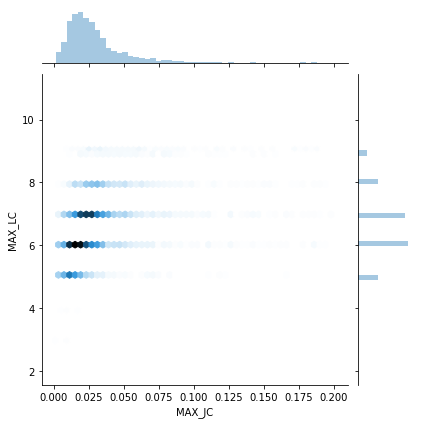

In [20]:
sns.jointplot(x="MAX_JC", y="MAX_LC", data=pr_count_pdf[(pr_count_pdf["MAX_LC"] < 12) & (pr_count_pdf["MAX_JC"]<0.2)], kind="hex");

### Check overall matching box-plot

In [21]:
some_pr_df = spark.sql("SELECT CONTENT_ID, JCS, SIZE_LCS,WORD_COUNT_DIFF, LCS, CONTENT_PUBLISH_DATE, ARTICLE_PUBLISH_DATE FROM matchings ORDER BY SIZE_LCS DESC")
some_pr_df.count()

416351

In [22]:
some_pr_df.printSchema()

root
 |-- CONTENT_ID: long (nullable = true)
 |-- JCS: double (nullable = true)
 |-- SIZE_LCS: string (nullable = true)
 |-- WORD_COUNT_DIFF: long (nullable = true)
 |-- LCS: string (nullable = true)
 |-- CONTENT_PUBLISH_DATE: string (nullable = true)
 |-- ARTICLE_PUBLISH_DATE: string (nullable = true)



In [23]:
pf_df = some_pr_df.toPandas()

In [24]:
pf_df["SIZE_LCS"] = pd.to_numeric(pf_df["SIZE_LCS"])
pf_df["JCS"] = pd.to_numeric(pf_df["JCS"])
pf_df["CONTENT_ID"] = pd.to_numeric(pf_df["CONTENT_ID"])
pf_df["WORD_COUNT_DIFF"] = pf_df["WORD_COUNT_DIFF"].abs()


In [25]:
pf_df.sort_values(by=['SIZE_LCS'], ascending=False).head()

,CONTENT_ID,JCS,SIZE_LCS,WORD_COUNT_DIFF,LCS,CONTENT_PUBLISH_DATE,ARTICLE_PUBLISH_DATE
167375,2976904,0.994695,588,48,Azotosomidn har väckt uppmärksamhet inom astr...,2020-03-02T06:00:00.000Z,2020-03-02T07:06:47.000Z
383174,2985564,0.965657,452,50,Förvärvet har genomförts i ett joint venture ...,2020-03-26T06:05:49.368Z,2020-03-26T10:14:31.000Z
383893,398010,0.987654,408,15,Vilka konsekvenser som följer av att en part...,2020-03-24T09:36:58.317Z,2020-03-24T10:08:54.000Z
383894,91576,0.995960,407,35,Den senaste veckan har nyheterna duggat tätt ...,2020-03-24T12:47:31.127Z,2020-03-25T11:00:02.000Z
391599,2984067,0.997996,391,39,Intaget av primära energikällor som kolhydrat...,2020-03-23T07:10:00.000Z,2020-03-23T07:40:36.000Z


In [26]:
sns.set(rc={'figure.figsize':(20.7,8.27)})

In [27]:
# %%time
# sns.boxplot(y='JCS', x='CONTENT_ID', data=pf_df)

## Relarion between SIZE_LCS and JCS 

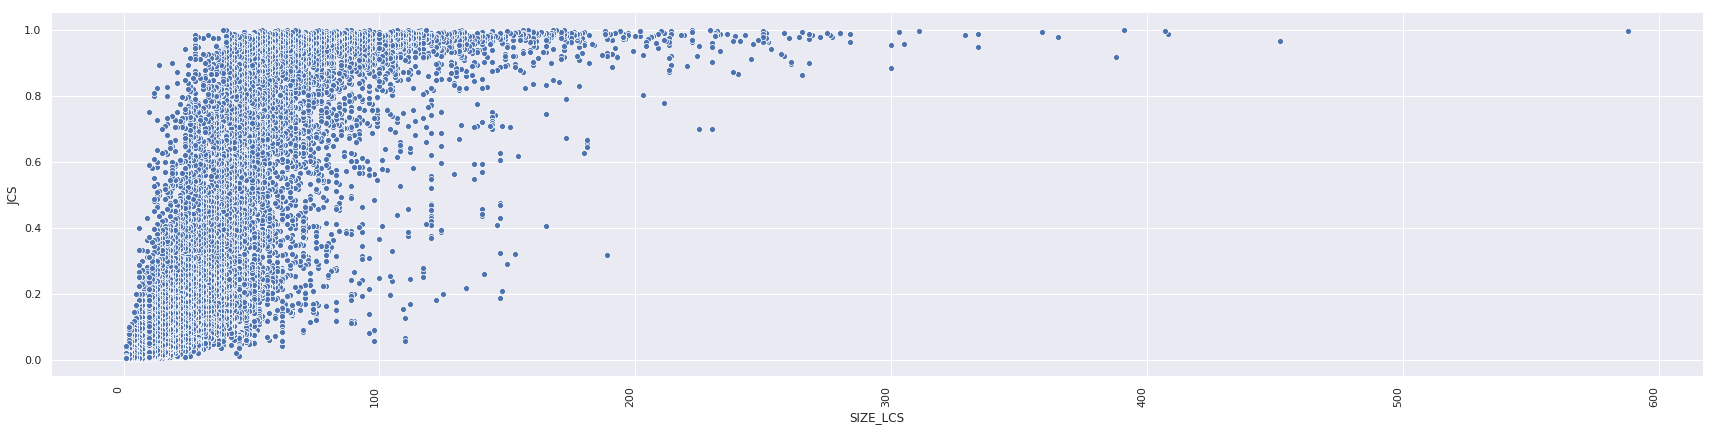

In [28]:
# sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.relplot(x="SIZE_LCS", y="JCS", data=pf_df, height=6, aspect=4)
ch.set_xticklabels(rotation=90, horizontalalignment='right')

### Concentrate SIZE_LCS < 100

In [29]:
pf_df_zoom = pf_df[pf_df.SIZE_LCS < 50]

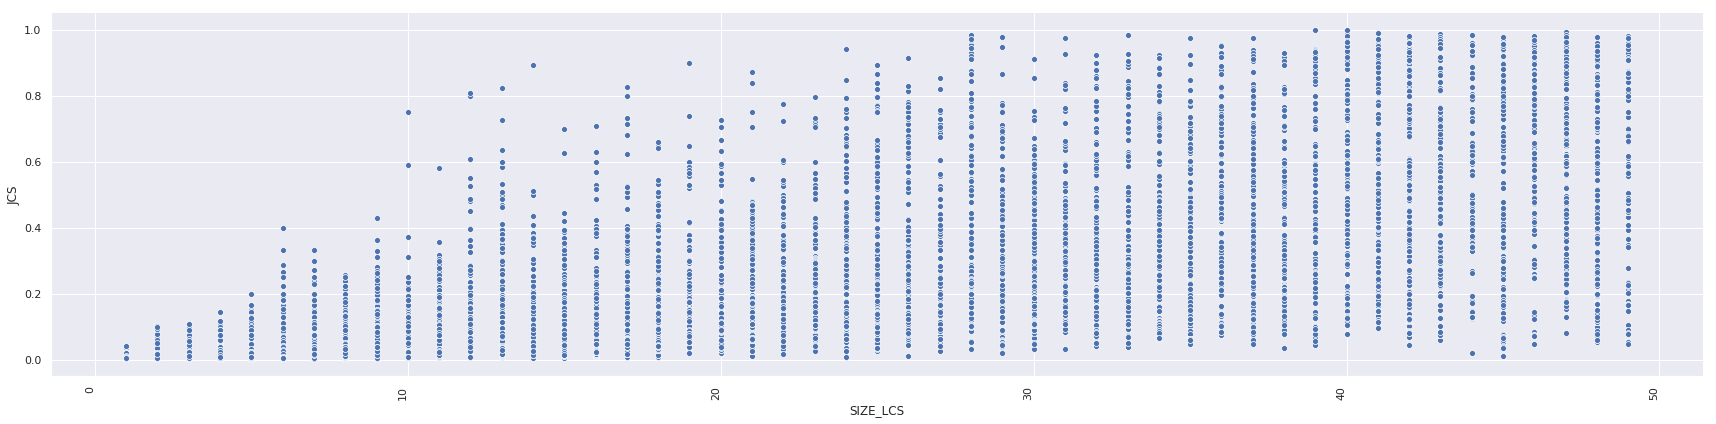

In [30]:
# sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.relplot(x="SIZE_LCS", y="JCS", data=pf_df_zoom, height=6, aspect=4)
ch.set_xticklabels(rotation=90, horizontalalignment='right')

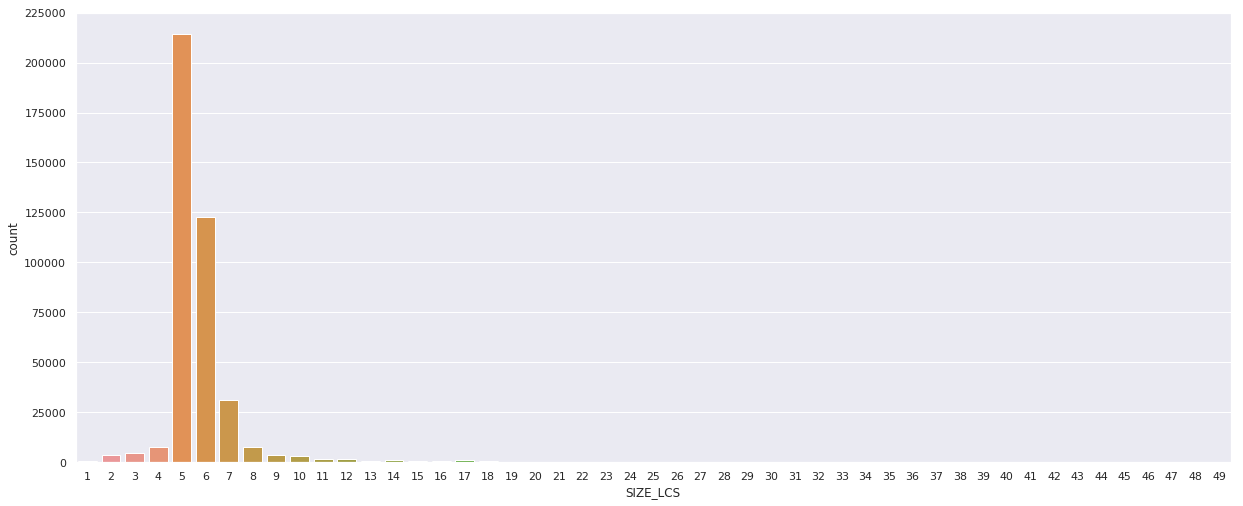

In [31]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.countplot(x="SIZE_LCS", data=pf_df_zoom)


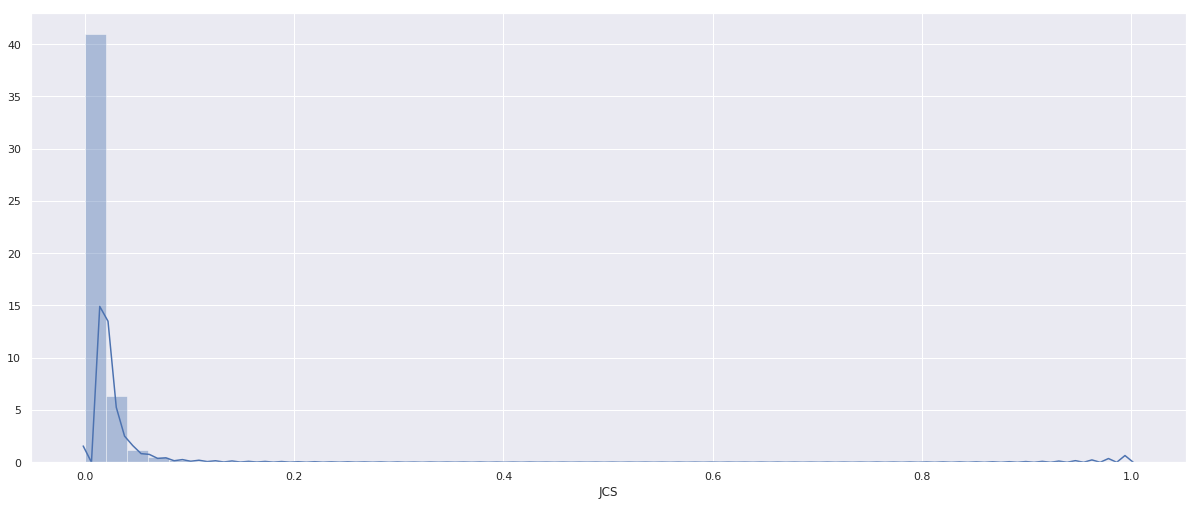

In [32]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.distplot(pf_df_zoom['JCS'])


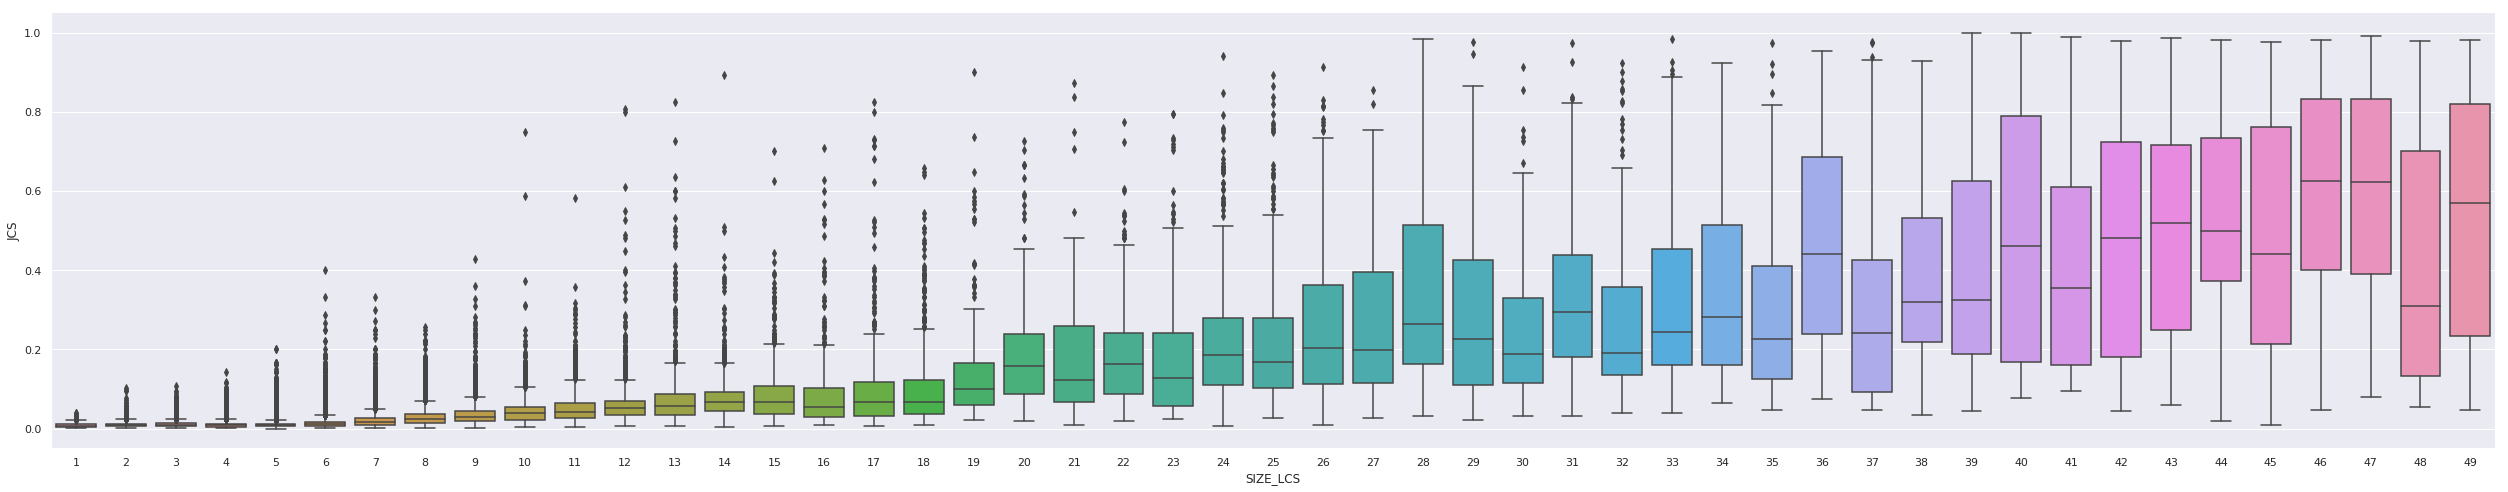

In [33]:
#sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.catplot(x="SIZE_LCS", y="JCS", kind="box", data=pf_df_zoom,height=7, aspect=5);

### Observe
- SIZE_LCS of 10 to 30 will have some  outlies which are the original matchings.
- SIZE_LCS=19 has third quartile bellow 0.2 JCS with outliers    >>  75% of SIZE_LCS=19 is not a good JCS for most matchings but still have some good JCS 
- SIZE_LCS=10 has third quartile bellow 0.4 JCS with no outliers >> 100% of SIZE_LCS=10 is not a good match 


### Question: What are those matches that are SIZE_LCS < 20 but 
### JCS > 0.8
Are they really a match with human level conformation?

In [34]:
pf_df[(pf_df["SIZE_LCS"] < 20) & (pf_df["JCS"] > 0.8)]

,CONTENT_ID,JCS,SIZE_LCS,WORD_COUNT_DIFF,LCS,CONTENT_PUBLISH_DATE,ARTICLE_PUBLISH_DATE
403254,2983958,0.900000,19,4,Colliers International har agerat rådgivare ...,2020-03-26T05:15:00.000Z,2020-03-26T10:58:00.000Z
404600,2983399,0.825000,17,40,Information om att Malmö stads gymnasier och...,2020-03-19T08:07:43.604Z,2020-03-19T09:19:11.000Z
407411,2986916,0.893333,14,28,för april. Även utställarna flyttas också öve...,2020-03-30T16:05:18.336Z,2020-03-31T05:19:17.000Z
408538,2962735,0.823529,13,34,ok för OKQ8s butiker i Sverige och erbjuder s...,2020-03-10T09:10:00.000Z,2020-03-13T09:05:20.000Z
410136,2985332,0.806452,12,22,består av bostäder och ett modernt LSSboende...,2020-03-26T07:00:00.000Z,2020-03-26T08:24:00.000Z


In [35]:
pf_df[(pf_df["SIZE_LCS"] < 20) & (pf_df["JCS"] > 0.8)]['LCS'].values[0]

'  Colliers International har agerat rådgivare åt restaurangkedjan MAX Burgers vid förvärvet av fastigheten Yrkesskolan 5 i Tumba utanför Stockholm. '

### JCS > 0.7

In [36]:
pf_df[(pf_df["SIZE_LCS"] < 20) & (pf_df["JCS"] > 0.7)]

,CONTENT_ID,JCS,SIZE_LCS,WORD_COUNT_DIFF,LCS,CONTENT_PUBLISH_DATE,ARTICLE_PUBLISH_DATE
403254,2983958,0.900000,19,4,Colliers International har agerat rådgivare ...,2020-03-26T05:15:00.000Z,2020-03-26T10:58:00.000Z
403269,2986337,0.736842,19,22,en medverkar kommunstyrelsens ordförande Robi...,2020-03-30T05:00:00.000Z,2020-03-30T08:19:52.000Z
404443,2983683,0.728395,17,29,. Stationen erbjuder kontrollbesiktning av pe...,2020-03-20T06:00:00.000Z,2020-03-20T12:56:00.000Z
404600,2983399,0.825000,17,40,Information om att Malmö stads gymnasier och...,2020-03-19T08:07:43.604Z,2020-03-19T09:19:11.000Z
404681,2979489,0.800000,17,25,I januari startade Mimikry sin resa med att s...,2020-03-06T08:59:00.000Z,2020-03-06T11:11:40.000Z
404787,2985131,0.730496,17,162,ge handlarna egen kontroll med automatiserad...,2020-03-25T07:19:00.000Z,2020-03-31T18:00:00.000Z
404955,396447,0.714286,17,10,Tälten är utrustade med meshventiler samt har...,2020-03-09T09:00:00.000Z,2020-03-10T06:06:35.000Z
404985,2979489,0.714286,17,17,I januari startade Mimikry sin resa med att s...,2020-03-06T08:59:00.000Z,2020-03-07T08:20:49.000Z
405260,2979496,0.709091,16,91,ledningsrör. Skärens design ger ett smidigt ...,2020-03-06T07:39:14.010Z,2020-03-31T06:30:00.000Z
407411,2986916,0.893333,14,28,för april. Även utställarna flyttas också öve...,2020-03-30T16:05:18.336Z,2020-03-31T05:19:17.000Z


In [37]:
pf_df[(pf_df["SIZE_LCS"] < 20) & (pf_df["JCS"] > 0.7)]['LCS'].values[:]

array(['  Colliers International har agerat rådgivare åt restaurangkedjan MAX Burgers vid förvärvet av fastigheten Yrkesskolan 5 i Tumba utanför Stockholm. ',
       ' en medverkar kommunstyrelsens ordförande Robin Holmberg vice ordförande Liss Böcker andre vice ordförande Lars Nyander och kommundirektör Lilian Eriksson.',
       ' . Stationen erbjuder kontrollbesiktning av personbilar lätta lastbilar släp och husvagnar upp till 35 ton samt motorcyklar. ',
       '  Information om att Malmö stads gymnasier och vuxenutbildning inklusive Yrkeshögskolan i dag ställer om till nätbaserad undervisning',
       ' I januari startade Mimikry sin resa med att släppa en singel i månaden digitalt under hela 2020.',
       '  ge handlarna egen kontroll med automatiserade flöden så att de smidigt kan lösa sin egen kundtjänsthantering och ',
       ' Tälten är utrustade med meshventiler samt har filtrerad strömförsörjning för egen infrastruktur inne i den skyddande miljön.',
       ' I januari starta

### JCS > 0.6

In [38]:
pf_df[(pf_df["SIZE_LCS"] < 20) & (pf_df["JCS"] > 0.6)]

,CONTENT_ID,JCS,SIZE_LCS,WORD_COUNT_DIFF,LCS,CONTENT_PUBLISH_DATE,ARTICLE_PUBLISH_DATE
403254,2983958,0.900000,19,4,Colliers International har agerat rådgivare ...,2020-03-26T05:15:00.000Z,2020-03-26T10:58:00.000Z
403269,2986337,0.736842,19,22,en medverkar kommunstyrelsens ordförande Robi...,2020-03-30T05:00:00.000Z,2020-03-30T08:19:52.000Z
403386,2978142,0.648148,19,54,Sea shanties emigrantvisor kärleksballader oc...,2020-03-03T09:56:00.000Z,2020-03-15T23:41:29.000Z
403650,2981338,0.647887,18,147,. Anledningen är att Länsstyrelsen bedriver s...,2020-03-12T11:35:00.000Z,2020-03-12T11:53:00.000Z
403727,2981338,0.658824,18,129,. Anledningen är att Länsstyrelsen bedriver s...,2020-03-12T11:35:00.000Z,2020-03-12T11:53:00.000Z
403746,397928,0.640000,18,62,Prata gärna med mig eller mina kollegor om pa...,2020-03-27T08:09:08.213Z,2020-03-30T05:45:01.000Z
404166,2986863,0.622222,17,226,oronaviruset väljer Gavlegårdarna att vid mån...,2020-03-30T13:58:34.193Z,2020-03-31T15:38:47.000Z
404443,2983683,0.728395,17,29,. Stationen erbjuder kontrollbesiktning av pe...,2020-03-20T06:00:00.000Z,2020-03-20T12:56:00.000Z
404600,2983399,0.825000,17,40,Information om att Malmö stads gymnasier och...,2020-03-19T08:07:43.604Z,2020-03-19T09:19:11.000Z
404681,2979489,0.800000,17,25,I januari startade Mimikry sin resa med att s...,2020-03-06T08:59:00.000Z,2020-03-06T11:11:40.000Z


In [39]:
pf_df[(pf_df["SIZE_LCS"] < 20) & (pf_df["JCS"] > 0.6)]['LCS'].values[:]

array(['  Colliers International har agerat rådgivare åt restaurangkedjan MAX Burgers vid förvärvet av fastigheten Yrkesskolan 5 i Tumba utanför Stockholm. ',
       ' en medverkar kommunstyrelsens ordförande Robin Holmberg vice ordförande Liss Böcker andre vice ordförande Lars Nyander och kommundirektör Lilian Eriksson.',
       ' Sea shanties emigrantvisor kärleksballader och sånger om storslagna äventyr till havs utgör stommen i detta saltstänkta och tjärdoftande konsertprogram',
       ' . Anledningen är att Länsstyrelsen bedriver samhällsviktig verksamhet och har lagstadgade uppgifter både regionalt och nationellt inom krisberedskapen ',
       ' . Anledningen är att Länsstyrelsen bedriver samhällsviktig verksamhet och har lagstadgade uppgifter både regionalt och nationellt inom krisberedskapen ',
       ' Prata gärna med mig eller mina kollegor om passagesystemet ACT och alla dess fördelar för ditt nästa säkerhetsprojekt.',
       ' oronaviruset väljer Gavlegårdarna att vid månad

### JCS < 0.4

In [40]:
pf_df[(pf_df["SIZE_LCS"] < 20) & (pf_df["JCS"] < 0.4)].head()

,CONTENT_ID,JCS,SIZE_LCS,WORD_COUNT_DIFF,LCS,CONTENT_PUBLISH_DATE,ARTICLE_PUBLISH_DATE
285,2981754,0.055556,9,249,en åtgärd för att mildra de ekonomiska konse...,2020-03-13T12:07:30.130Z,2020-03-27T11:09:04.000Z
286,2985162,0.053333,9,153,grund av den osäkerhet som råder med anlednin...,2020-03-25T07:32:15.698Z,2020-03-27T13:00:00.000Z
287,2984635,0.051282,9,412,är skyldigt att offentliggöra enligt EUs mar...,2020-03-23T20:01:00.000Z,2020-03-27T11:33:00.000Z
288,2984635,0.048000,9,384,är skyldigt att offentliggöra enligt EUs mar...,2020-03-23T20:01:00.000Z,2020-03-27T13:00:00.000Z
289,2983345,0.046296,9,35,att göra vad vi kan för att minska smittspri...,2020-03-18T16:30:00.000Z,2020-03-27T11:19:38.000Z


In [41]:
pf_df[(pf_df["SIZE_LCS"] < 20) & (pf_df["JCS"] < 0.4)]['LCS'].head().values[:]

array(['  en åtgärd för att mildra de ekonomiska konsekvenserna av ',
       ' grund av den osäkerhet som råder med anledning av ',
       '  är skyldigt att offentliggöra enligt EUs marknadsmissbruksförordning. Informationen lämnades ',
       '  är skyldigt att offentliggöra enligt EUs marknadsmissbruksförordning. Informationen lämnades ',
       '  att göra vad vi kan för att minska smittspridningen '],
      dtype=object)

In [42]:
# save_pd_df = pf_df[(pf_df["SIZE_LCS"] < 20) & (pf_df["JCS"] > 0.6)]
# save_pd_df.to_csv('Suspecious_Matching.csv')

### Hypothesis 01: With out the name entity the matchings can be regarder as not-random match.

#### Exception 01

In [43]:
hypo_df = spark.sql("SELECT CONTENT_ID, JCS, SIZE_LCS,WORD_COUNT_DIFF, LCS, CONTENT_PUBLISH_DATE, ARTICLE_PUBLISH_DATE, ARTICLE_SOURCE, ARTICLE_TEXT, ARTICLE_URL, CONTENT_TEXT FROM matchings \
WHERE CONTENT_ID = 2983683 AND WORD_COUNT_DIFF = 29")
#  AND SIZE_LCS = '17' AND JCS = 0.839286 AND
hypo_df.show()



+----------+------------------+--------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CONTENT_ID|               JCS|SIZE_LCS|WORD_COUNT_DIFF|                 LCS|CONTENT_PUBLISH_DATE|ARTICLE_PUBLISH_DATE|      ARTICLE_SOURCE|        ARTICLE_TEXT|         ARTICLE_URL|        CONTENT_TEXT|
+----------+------------------+--------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   2983683|0.7283950617283951|     17 |             29| . Stationen erbj...|2020-03-20T06:00:...|2020-03-20T12:56:...|{"id":47476,"name...|Opus öppnar ny st...|https://www.motor...|Ny Opusstation öp...|
+----------+------------------+--------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--

In [44]:
hypo_df.printSchema()

root
 |-- CONTENT_ID: long (nullable = true)
 |-- JCS: double (nullable = true)
 |-- SIZE_LCS: string (nullable = true)
 |-- WORD_COUNT_DIFF: long (nullable = true)
 |-- LCS: string (nullable = true)
 |-- CONTENT_PUBLISH_DATE: string (nullable = true)
 |-- ARTICLE_PUBLISH_DATE: string (nullable = true)
 |-- ARTICLE_SOURCE: string (nullable = true)
 |-- ARTICLE_TEXT: string (nullable = true)
 |-- ARTICLE_URL: string (nullable = true)
 |-- CONTENT_TEXT: string (nullable = true)



In [45]:
# PR
hypo_df.take(1)[0][10]

'Ny Opusstation öppnad i centrala Malmö Fredag 20 mars öppnar Opus Bilprovnings nya station i Malmö  på Borrgatan 1F. Stationen erbjuder kontrollbesiktning av personbilar lätta lastbilar släp och husvagnar upp till 35 ton samt motorcyklar. Idag fredag 20 mars öppnar Opus Bilprovnings nya station på Borrgatani Malmö. Vi har sett en stor efterfrågan av vår närvaro i södra Sverige så nu öppnar vi vår andra anläggning i Malmö som ligger helt i vår plan att vara tillgängliga för våra kunder säger Tord Fornander vice vd på Opus Bilprovning. Opus Bilprovnings nya anläggning på Borrgatan 1F i Malmö är centralt placerad med mindre än 2 km till Malmö Centralstation. I samma fastighet finns även bilverkstad bildelsbutik samt biltvätt berättar stationschef Victor Janson.Stationen erbjuder kontrollbesiktning av personbilar lätta lastbilar släp och husvagnar upp till 35 ton samt motorcyklar. Utöver detta görs även frivilliga kontroller som gasolkontroll fukttest biltest och andra typer av tester som

In [46]:
# Article
hypo_df.take(1)[0][8]

'Opus öppnar ny station i Malmö. Det går bra för bilbesiktningsbranschen. I alla fall för Opus som är en av fem större aktörer i Sverige. Marknadsandelen är cirka 25 procent. Läs också Härnösand får ny besiktningsstation  Vi har sett en stor efterfrågan av vår närvaro i södra Sverige så nu öppnar vi vår andra anläggning i Malmö säger Tord Fornander vice vd på Opus Bilprovning.  Vår nya anläggning på Borrgatan 1F i Malmö är centralt placerad med mindre än två km till Malmö Centralstation. I samma fastighet finns även bilverkstad bildelsbutik samt biltvätt säger stationschef Victor Janson. Stationen erbjuder kontrollbesiktning av personbilar lätta lastbilar släp och husvagnar upp till 35 ton samt motorcyklar. Dessutom görs även frivilliga kontroller som gasolkontroll fukttest biltest och andra typer av tester.  Vi kommer att öppna fler stationer under året säger Marika Ireblad Kommunikations och marknadschef Opus Bilprovning. Hon berättar även att företaget har cirka 500 besiktningstekni

In [47]:
# LCS
hypo_df.take(1)[0][4]

' . Stationen erbjuder kontrollbesiktning av personbilar lätta lastbilar släp och husvagnar upp till 35 ton samt motorcyklar. '

In [48]:
hypo_2_df = spark.sql("SELECT CONTENT_ID, JCS, SIZE_LCS,WORD_COUNT_DIFF, LCS, CONTENT_PUBLISH_DATE, ARTICLE_PUBLISH_DATE, ARTICLE_SOURCE, ARTICLE_TEXT, ARTICLE_URL, CONTENT_TEXT FROM matchings")
#  AND SIZE_LCS = '17' AND JCS = 0.839286 AND

def stripDQ(string):
    return string.replace(' ', "")

udf_stripDQ = udf(stripDQ, StringType())

hypo_3_df = hypo_2_df.withColumn("JCS_1", hypo_2_df["JCS"].cast(DoubleType()))
hypo_4_df = hypo_3_df.withColumn("SIZE_LCS_1", udf_stripDQ(hypo_3_df["SIZE_LCS"])  )
hypo_5_df = hypo_4_df.withColumn("SIZE_LCS_2", hypo_4_df["SIZE_LCS_1"].cast(IntegerType()))


hypo_5_df.filter("JCS_1 > 0.6 and SIZE_LCS_2 < 20 ").show()



+----------+------------------+--------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------+----------+
|CONTENT_ID|               JCS|SIZE_LCS|WORD_COUNT_DIFF|                 LCS|CONTENT_PUBLISH_DATE|ARTICLE_PUBLISH_DATE|      ARTICLE_SOURCE|        ARTICLE_TEXT|         ARTICLE_URL|        CONTENT_TEXT|             JCS_1|SIZE_LCS_1|SIZE_LCS_2|
+----------+------------------+--------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------+----------+
|   2986863|0.6222222222222222|     17 |            226| oronaviruset väl...|2020-03-30T13:58:...|2020-03-31T15:38:...|{"id":166109,"nam...|Nyckelhantering u...|https://forvaltar...|Gavlegårdarna skö...|0.6222222222222222|        17|        17|
|   2979496|0.709090

In [49]:
hypo_pd_df = hypo_5_df.filter("JCS_1 > 0.6 and SIZE_LCS_2 < 20 ").toPandas()
# hypo_pd_df.to_csv('Suspecious_Matching_March.csv')
# hypo_pd_df.to_json("Suspecious_Matching_March.json",orient='index')


In [50]:
# hypo_pd_df_1 = hypo_5_df.filter("JCS_1 > 0.2 and JCS_1 < 0.3").toPandas()
# hypo_pd_df_1.head()
# hypo_pd_df_1.shape

In [51]:
# hypo_pd_df_1.sort_values(by=['SIZE_LCS_2'], ascending=False).head()

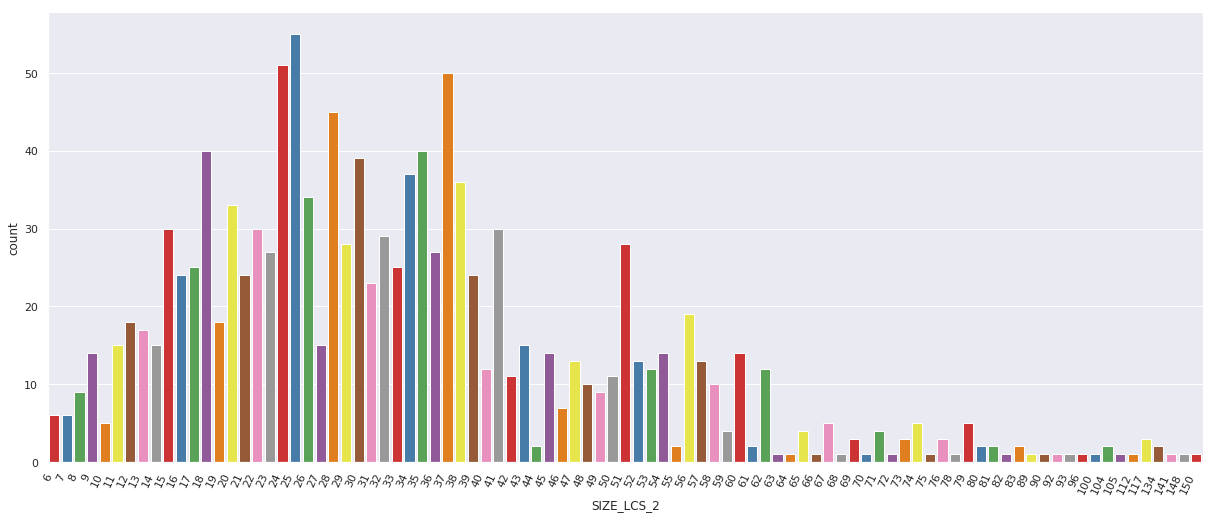

In [52]:
# sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.countplot(x="SIZE_LCS_2", data=hypo_5_df.filter("JCS_1 > 0.2 and JCS_1 < 0.3").toPandas().sort_values(by=['SIZE_LCS_2'], ascending=False),  palette='Set1')
ch.set_xticklabels( ch.get_xticklabels(), rotation=65, horizontalalignment='right');

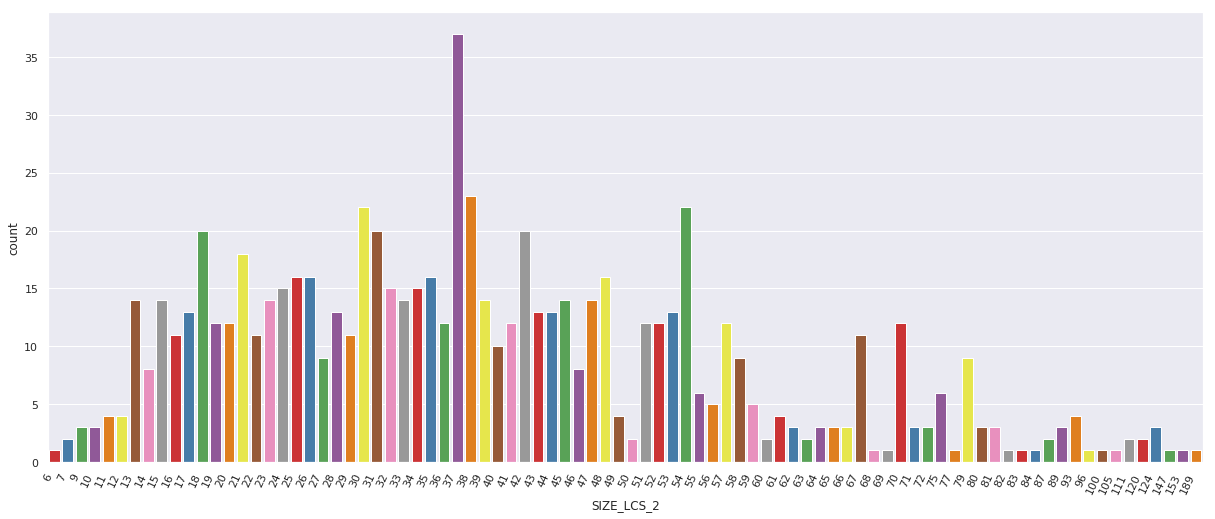

In [53]:
# sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.countplot(x="SIZE_LCS_2", data=hypo_5_df.filter("JCS_1 > 0.3 and JCS_1 < 0.4").toPandas().sort_values(by=['SIZE_LCS_2'], ascending=False),  palette='Set1')
ch.set_xticklabels( ch.get_xticklabels(), rotation=65, horizontalalignment='right'); # This semicholone will prevent a list of text before the graph

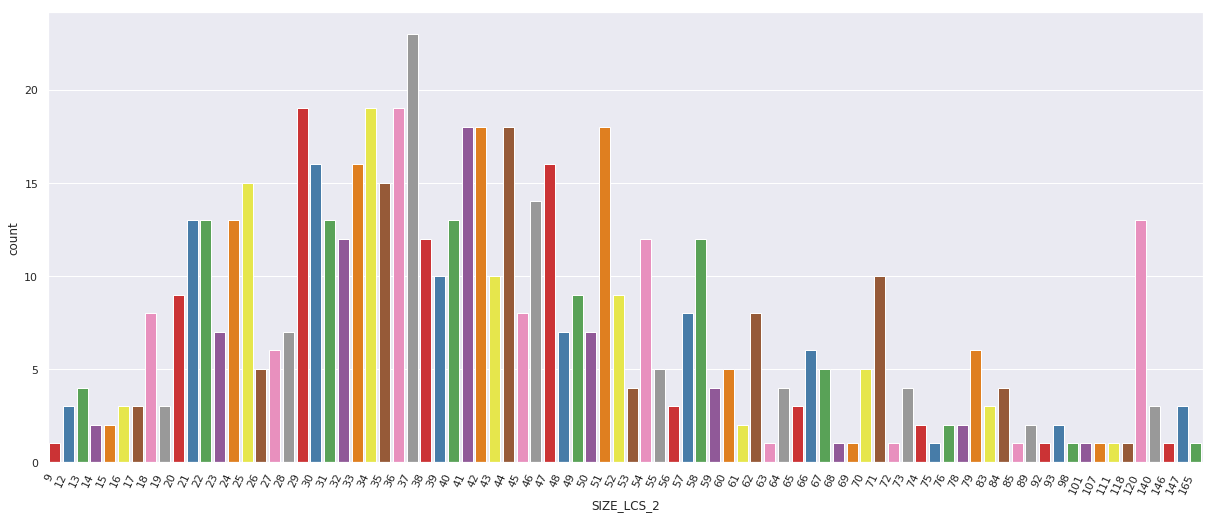

In [54]:
# sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.countplot(x="SIZE_LCS_2", data=hypo_5_df.filter("JCS_1 > 0.4 and JCS_1 < 0.5").toPandas().sort_values(by=['SIZE_LCS_2'], ascending=False),  palette='Set1')
ch.set_xticklabels(ch.get_xticklabels(), rotation=65, horizontalalignment='right'); # This semicholone will prevent a list of text before the graph

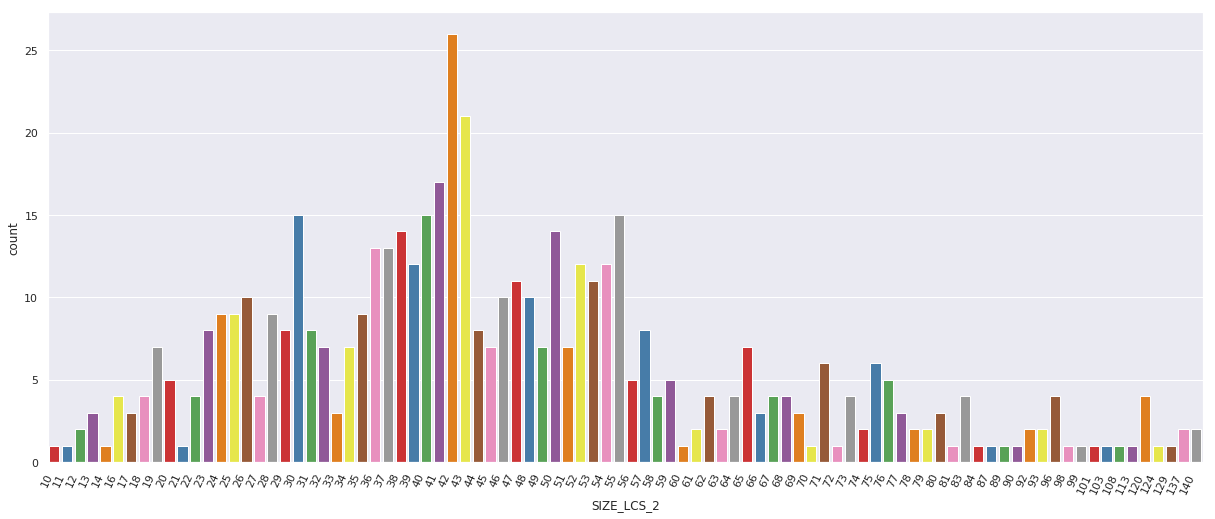

In [55]:
# sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.countplot(x="SIZE_LCS_2", data=hypo_5_df.filter("JCS_1 > 0.5 and JCS_1 < 0.6").toPandas().sort_values(by=['SIZE_LCS_2'], ascending=False),  palette='Set1')
ch.set_xticklabels( ch.get_xticklabels(), rotation=65, horizontalalignment='right'); # This semicholone will prevent a list of text before the graph

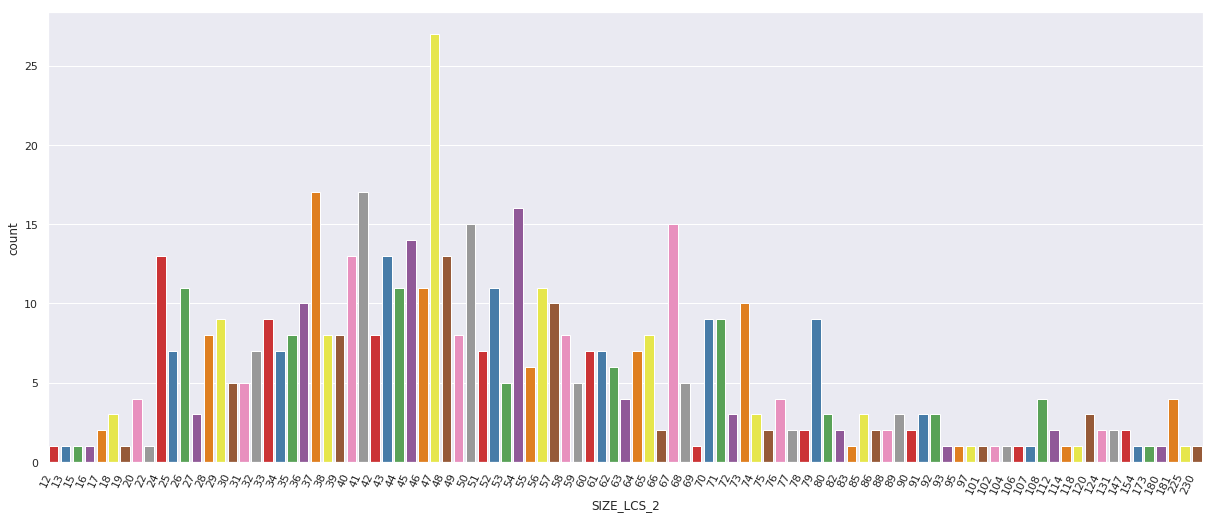

In [56]:
# sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.countplot(x="SIZE_LCS_2", data=hypo_5_df.filter("JCS_1 > 0.6 and JCS_1 < 0.7").toPandas().sort_values(by=['SIZE_LCS_2'], ascending=False),  palette='Set1')
ch.set_xticklabels( ch.get_xticklabels(), rotation=65, horizontalalignment='right'); # This semicholone will prevent a list of text before the graph

## Relarion between WORD_COUNT_DIFF and JCS 

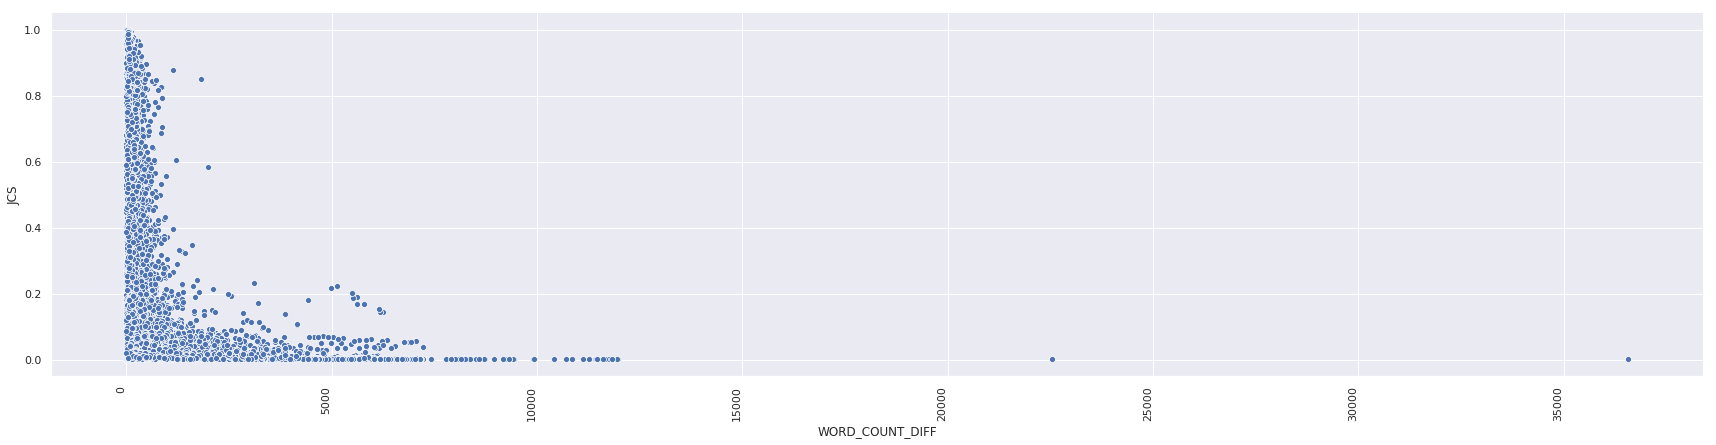

In [57]:
# sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.relplot(x="WORD_COUNT_DIFF", y="JCS", data=pf_df, height=6, aspect=4)
ch.set_xticklabels(rotation=90, horizontalalignment='right')

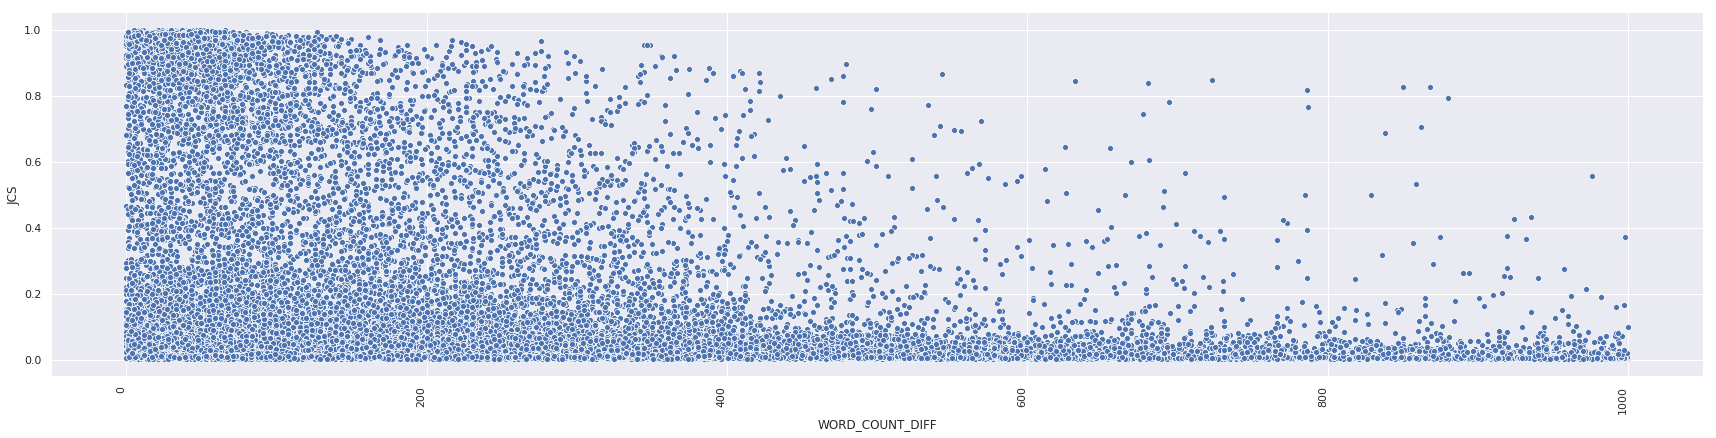

In [58]:
# sns.set(rc={'figure.figsize':(20.7,8.27)})
ch = sns.relplot(x="WORD_COUNT_DIFF", y="JCS", data=pf_df[pf_df["WORD_COUNT_DIFF"]<=1000], height=6, aspect=4)
ch.set_xticklabels(rotation=90, horizontalalignment='right')

### The JCS with probability density function

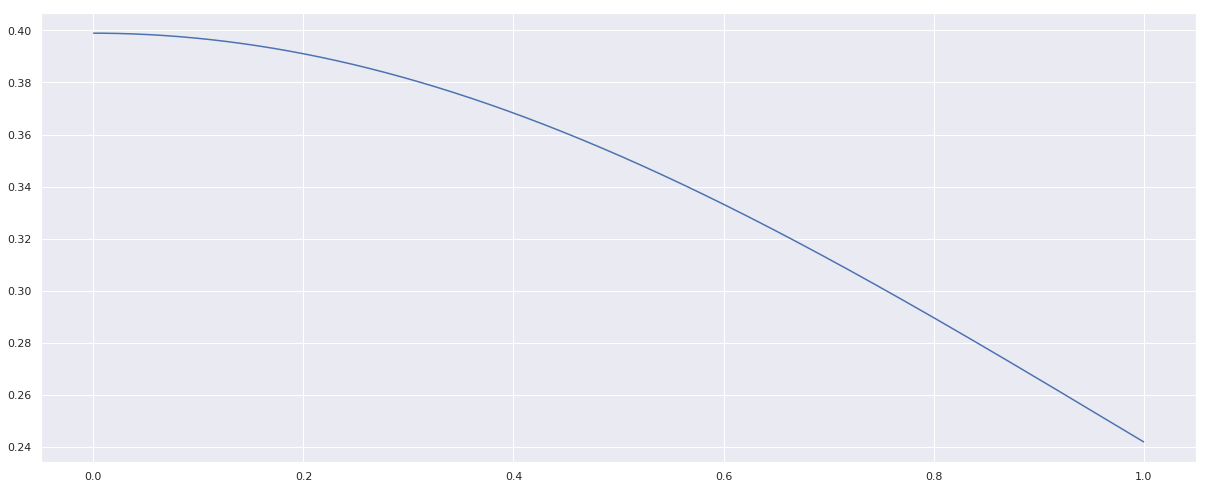

In [59]:
x_ax = pf_df.sort_values(by='JCS', ascending=False)['JCS']
y_ax = norm.pdf(x_ax)
plt.plot(x_ax, y_ax)
plt.show()

### Check indevidual content over time

In [14]:
one_pr_df = spark.sql("SELECT CONTENT_ID, JCS, SIZE_LCS,WORD_COUNT_DIFF, LCS, CONTENT_PUBLISH_DATE, ARTICLE_PUBLISH_DATE FROM matchings WHERE CONTENT_ID = '2977000' ORDER BY ARTICLE_PUBLISH_DATE")
one_pr_df.show()

+----------+--------------------+--------+---------------+--------------------+--------------------+--------------------+
|CONTENT_ID|                 JCS|SIZE_LCS|WORD_COUNT_DIFF|                 LCS|CONTENT_PUBLISH_DATE|ARTICLE_PUBLISH_DATE|
+----------+--------------------+--------+---------------+--------------------+--------------------+--------------------+
|   2977000|0.004901960784313708|      5 |            185|  som vi känner i...|2020-03-12T07:30:...|2007-03-16T01:15:...|
|   2977000|0.004237288135593209|      6 |            -33| g är en av de mest |2020-03-12T07:30:...|2007-09-28T22:24:...|
|   2977000| 0.10483870967741937|     18 |            551| . För att tidigt...|2020-03-12T07:30:...|2020-03-12T06:30:...|
|   2977000|  0.9981718464351006|    107 |             30|  Språkstörning ä...|2020-03-12T07:30:...|2020-03-12T07:55:...|
|   2977000|  0.9867172675521821|    107 |             27|  Språkstörning ä...|2020-03-12T07:30:...|2020-03-12T12:34:...|
|   2977000|0.0018348623

In [15]:
one_pd = one_pr_df.toPandas()
# sns.set(rc={'figure.figsize':(20.7,8.27)})
# sns.boxplot(y='JCS', x='CONTENT_ID', data=one_pd)

chart = sns.catplot(y="JCS", x="ARTICLE_PUBLISH_DATE", kind="bar", data=one_pd, height=4, aspect=4);
chart.set_xticklabels(rotation=65, horizontalalignment='right')


AttributeError: module 'seaborn' has no attribute 'catplot'

In [ ]:
# one_pd['SIZE_LCS']

one_pd['SIZE_LCS'] = pd.to_numeric(one_pd['SIZE_LCS'])

chart = sns.catplot(y="SIZE_LCS", x="ARTICLE_PUBLISH_DATE", kind="bar", data=one_pd, height=4, aspect=4);
chart.set_xticklabels(rotation=65, horizontalalignment='right')

In [ ]:
one_pd

### Check the skew of the distribution with probability density function

In [ ]:
x_ax = one_pd.sort_values(by='JCS', ascending=False)['JCS']
y_ax = norm.pdf(x_ax)
x_ax 


In [ ]:
plt.plot(x_ax, y_ax)
plt.show()

In [ ]:
stats.skew(x_ax)

### Its a positive skew

In [ ]:
stats.kurtosis(x_ax)

### Check hits over time

In [12]:
sorted_pr_df_1 = spark.sql("SELECT CONTENT_ID, JCS, SIZE_LCS,WORD_COUNT_DIFF, CONTENT_PUBLISH_DATE, ARTICLE_PUBLISH_DATE FROM matchings ORDER BY CONTENT_ID, ARTICLE_PUBLISH_DATE")
# sorted_pr_df.count()

def stripDQ(string):
    return string.replace(' ', "")

udf_stripDQ = udf(stripDQ, StringType())

hypo_3_df = sorted_pr_df_1.withColumn("JCS_1", sorted_pr_df_1["JCS"].cast(DoubleType()))
hypo_4_df = hypo_3_df.withColumn("SIZE_LCS_1", udf_stripDQ(hypo_3_df["SIZE_LCS"])  )
hypo_5_df = hypo_4_df.withColumn("SIZE_LCS_2", hypo_4_df["SIZE_LCS_1"].cast(IntegerType()))

sorted_pr_df = hypo_5_df.filter("JCS_1 > 0.0002 and SIZE_LCS_2 > 3 ")

sorted_pr_df.show()

+----------+--------------------+--------+---------------+--------------------+--------------------+--------------------+----------+----------+
|CONTENT_ID|                 JCS|SIZE_LCS|WORD_COUNT_DIFF|CONTENT_PUBLISH_DATE|ARTICLE_PUBLISH_DATE|               JCS_1|SIZE_LCS_1|SIZE_LCS_2|
+----------+--------------------+--------+---------------+--------------------+--------------------+--------------------+----------+----------+
|     52186|0.007518796992481258|      6 |           -644|2020-03-02T07:04:...|2020-03-17T15:27:...|0.007518796992481258|         6|         6|
|     52253|0.025974025974025983|      6 |           -209|2020-02-10T07:03:...|2020-03-01T11:00:...|0.025974025974025983|         6|         6|
|     52253|0.007092198581560294|      5 |           -790|2020-02-10T07:03:...|2020-03-03T05:23:...|0.007092198581560294|         5|         5|
|     52253| 0.05263157894736836|      7 |            -43|2020-02-10T07:03:...|2020-03-04T12:41:...| 0.05263157894736836|         7|    

In [13]:
sorted_pdf = sorted_pr_df.toPandas()
sorted_pdf.shape

(407746, 9)

In [14]:
sorted_pdf["SIZE_LCS"] = pd.to_numeric(sorted_pdf["SIZE_LCS"])
sorted_pdf["JCS"] = pd.to_numeric(sorted_pdf["JCS"])
sorted_pdf["CONTENT_ID"] = pd.to_numeric(sorted_pdf["CONTENT_ID"])
sorted_pdf["WORD_COUNT_DIFF"] = sorted_pdf["WORD_COUNT_DIFF"].abs()
sorted_pdf["ARTICLE_PUBLISH_DATE"] = pd.to_datetime(sorted_pdf["ARTICLE_PUBLISH_DATE"], format='%Y%m%dT%H:%M:%S')
sorted_pdf.head()

,CONTENT_ID,JCS,SIZE_LCS,WORD_COUNT_DIFF,CONTENT_PUBLISH_DATE,ARTICLE_PUBLISH_DATE,JCS_1,SIZE_LCS_1,SIZE_LCS_2
0,52186,0.007519,6,644,2020-03-02T07:04:00.000Z,2020-03-17 15:27:34+00:00,0.007519,6,6
1,52253,0.025974,6,209,2020-02-10T07:03:00.000Z,2020-03-01 11:00:00+00:00,0.025974,6,6
2,52253,0.007092,5,790,2020-02-10T07:03:00.000Z,2020-03-03 05:23:13+00:00,0.007092,5,5
3,52253,0.052632,7,43,2020-02-10T07:03:00.000Z,2020-03-04 12:41:16+00:00,0.052632,7,7
4,52253,0.009302,6,1702,2020-02-10T07:03:00.000Z,2020-03-08 13:08:36+00:00,0.009302,6,6


In [15]:
# sorted_pdf.groupby(lambda x: x.CONTENT_ID).transform(lambda x: x.count())
# sorted_pdf.groupby('CONTENT_ID')['JCS'].apply(list).reset_index(name='JCS_LIST')

listed_pdf = sorted_pdf.groupby('CONTENT_ID')['JCS'].agg(list).reset_index(name='JCS_LIST')
print("The size is : ", listed_pdf.shape)
listed_pdf.head()

The size is :  (8292, 2)


,CONTENT_ID,JCS_LIST
0,52186,[0.007518796992481258]
1,52253,"[0.025974025974025983, 0.007092198581560294, 0..."
2,82025,"[0.011173184357541888, 0.005813953488372103, 0..."
3,84741,"[0.010309278350515427, 0.006711409395973145, 0..."
4,87347,"[0.015151515151515138, 0.014218009478673022, 0..."


In [16]:
# Transform creates same amount of rows as sourse DF - so you can create a new column in source DF
sorted_pdf["HIT_COUNT"] = sorted_pdf.groupby('CONTENT_ID')['JCS'].transform(lambda x: x.count())

In [17]:
sorted_pdf.head()

,CONTENT_ID,JCS,SIZE_LCS,WORD_COUNT_DIFF,CONTENT_PUBLISH_DATE,ARTICLE_PUBLISH_DATE,JCS_1,SIZE_LCS_1,SIZE_LCS_2,HIT_COUNT
0,52186,0.007519,6,644,2020-03-02T07:04:00.000Z,2020-03-17 15:27:34+00:00,0.007519,6,6,1.0
1,52253,0.025974,6,209,2020-02-10T07:03:00.000Z,2020-03-01 11:00:00+00:00,0.025974,6,6,10.0
2,52253,0.007092,5,790,2020-02-10T07:03:00.000Z,2020-03-03 05:23:13+00:00,0.007092,5,5,10.0
3,52253,0.052632,7,43,2020-02-10T07:03:00.000Z,2020-03-04 12:41:16+00:00,0.052632,7,7,10.0
4,52253,0.009302,6,1702,2020-02-10T07:03:00.000Z,2020-03-08 13:08:36+00:00,0.009302,6,6,10.0


In [18]:
sorted_pdf["HIT_INDEX"] = 0

run = 0
prv_cont_id = '00000'
counter = 0
for ind_x, x in sorted_pdf.iterrows():
    
   
    if prv_cont_id == x['CONTENT_ID']:
        counter +=1
    else:
        counter = 0
    
    sorted_pdf.at[ind_x,"HIT_INDEX"] = x["HIT_COUNT"] - counter
    
    prv_cont_id = x['CONTENT_ID']
    
    # print(f' ---- Prev: {prv_cont_id}  Current: {x["CONTENT_ID"]} counter {counter}')
    # run += 1
    # if run > 50:
    #     break
    
    
sorted_pdf.head()

,CONTENT_ID,JCS,SIZE_LCS,WORD_COUNT_DIFF,CONTENT_PUBLISH_DATE,ARTICLE_PUBLISH_DATE,JCS_1,SIZE_LCS_1,SIZE_LCS_2,HIT_COUNT,HIT_INDEX
0,52186,0.007519,6,644,2020-03-02T07:04:00.000Z,2020-03-17 15:27:34+00:00,0.007519,6,6,1.0,1
1,52253,0.025974,6,209,2020-02-10T07:03:00.000Z,2020-03-01 11:00:00+00:00,0.025974,6,6,10.0,10
2,52253,0.007092,5,790,2020-02-10T07:03:00.000Z,2020-03-03 05:23:13+00:00,0.007092,5,5,10.0,9
3,52253,0.052632,7,43,2020-02-10T07:03:00.000Z,2020-03-04 12:41:16+00:00,0.052632,7,7,10.0,8
4,52253,0.009302,6,1702,2020-02-10T07:03:00.000Z,2020-03-08 13:08:36+00:00,0.009302,6,6,10.0,7


In [19]:
chartit_pdf = sorted_pdf[(sorted_pdf['HIT_COUNT']<=55)]

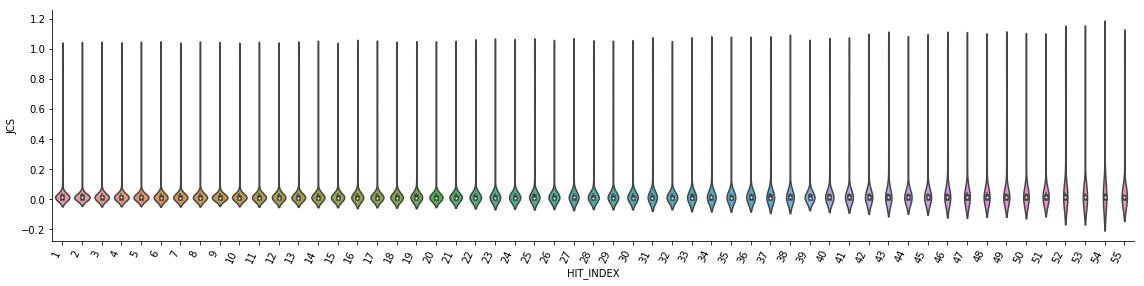

In [20]:
chart = sns.catplot(y="JCS", x="HIT_INDEX", kind="violin", data=chartit_pdf, height=4, aspect=4);
chart.set_xticklabels(rotation=65, horizontalalignment='right');

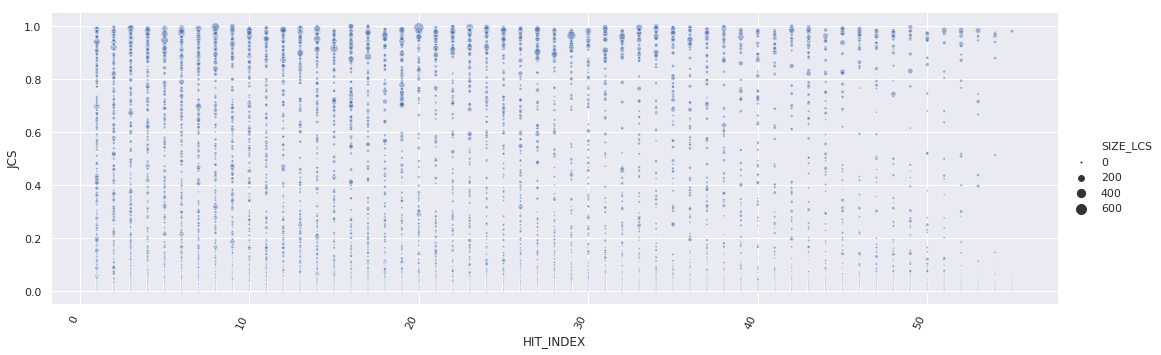

In [21]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
# ax = sns.lineplot(x="DAY_INDEX", y="JCS", hue="CONTENT_ID", data=chartit_pdf)
ax = sns.relplot(x="HIT_INDEX", y="JCS",  size="SIZE_LCS", sizes=(1, 100), alpha=.5, aspect=3,data=chartit_pdf) #hue="CONTENT_ID",
ax.set_xticklabels(rotation=65, horizontalalignment='right');

### Check hits over time (daily)

In [22]:
sorted_pdf.head()

,CONTENT_ID,JCS,SIZE_LCS,WORD_COUNT_DIFF,CONTENT_PUBLISH_DATE,ARTICLE_PUBLISH_DATE,JCS_1,SIZE_LCS_1,SIZE_LCS_2,HIT_COUNT,HIT_INDEX
0,52186,0.007519,6,644,2020-03-02T07:04:00.000Z,2020-03-17 15:27:34+00:00,0.007519,6,6,1.0,1
1,52253,0.025974,6,209,2020-02-10T07:03:00.000Z,2020-03-01 11:00:00+00:00,0.025974,6,6,10.0,10
2,52253,0.007092,5,790,2020-02-10T07:03:00.000Z,2020-03-03 05:23:13+00:00,0.007092,5,5,10.0,9
3,52253,0.052632,7,43,2020-02-10T07:03:00.000Z,2020-03-04 12:41:16+00:00,0.052632,7,7,10.0,8
4,52253,0.009302,6,1702,2020-02-10T07:03:00.000Z,2020-03-08 13:08:36+00:00,0.009302,6,6,10.0,7


In [23]:
daily_grouped_pdf = sorted_pdf.groupby(['CONTENT_ID',pd.Grouper(key='ARTICLE_PUBLISH_DATE',freq='D')])['JCS'] \
.agg([('f1',lambda x: x.max()), ('f2',lambda x: x.mean())]) \
.rename(columns={'f1': 'DAILY_MAX', 'f2': 'DAILY_AVG'}).reset_index()

daily_grouped_pdf.head()

,CONTENT_ID,ARTICLE_PUBLISH_DATE,DAILY_MAX,DAILY_AVG
0,52186,2020-03-17 00:00:00+00:00,0.007519,0.007519
1,52253,2020-03-01 00:00:00+00:00,0.025974,0.025974
2,52253,2020-03-03 00:00:00+00:00,0.007092,0.007092
3,52253,2020-03-04 00:00:00+00:00,0.052632,0.052632
4,52253,2020-03-08 00:00:00+00:00,0.009302,0.009302


In [24]:
# Transform creates same amount of rows as sourse DF - so you can create a new column in source DF
daily_grouped_pdf['DAILY_COUNT'] = daily_grouped_pdf.groupby('CONTENT_ID')['DAILY_MAX'].transform(lambda x: x.count())
daily_grouped_pdf.head()

,CONTENT_ID,ARTICLE_PUBLISH_DATE,DAILY_MAX,DAILY_AVG,DAILY_COUNT
0,52186,2020-03-17 00:00:00+00:00,0.007519,0.007519,1.0
1,52253,2020-03-01 00:00:00+00:00,0.025974,0.025974,7.0
2,52253,2020-03-03 00:00:00+00:00,0.007092,0.007092,7.0
3,52253,2020-03-04 00:00:00+00:00,0.052632,0.052632,7.0
4,52253,2020-03-08 00:00:00+00:00,0.009302,0.009302,7.0


In [25]:
daily_grouped_pdf["DAILY_INDEX"] = 0

run = 0
prv_cont_id = '00000'
counter = 0
for ind_x, x in daily_grouped_pdf.iterrows():
    
   
    if prv_cont_id == x['CONTENT_ID']:
        counter +=1
    else:
        counter = 0
    
    daily_grouped_pdf.at[ind_x,"DAILY_INDEX"] = x["DAILY_COUNT"] - counter
    
    prv_cont_id = x['CONTENT_ID']
    
    # print(f' ---- Prev: {prv_cont_id}  Current: {x["CONTENT_ID"]} counter {counter}')
    # run += 1
    # if run > 50:
    #     break
    
    
daily_grouped_pdf.head()

,CONTENT_ID,ARTICLE_PUBLISH_DATE,DAILY_MAX,DAILY_AVG,DAILY_COUNT,DAILY_INDEX
0,52186,2020-03-17 00:00:00+00:00,0.007519,0.007519,1.0,1
1,52253,2020-03-01 00:00:00+00:00,0.025974,0.025974,7.0,7
2,52253,2020-03-03 00:00:00+00:00,0.007092,0.007092,7.0,6
3,52253,2020-03-04 00:00:00+00:00,0.052632,0.052632,7.0,5
4,52253,2020-03-08 00:00:00+00:00,0.009302,0.009302,7.0,4


In [26]:
chartit_pdf = daily_grouped_pdf #[(daily_grouped_pdf['DAILY_COUNT']<=30)]

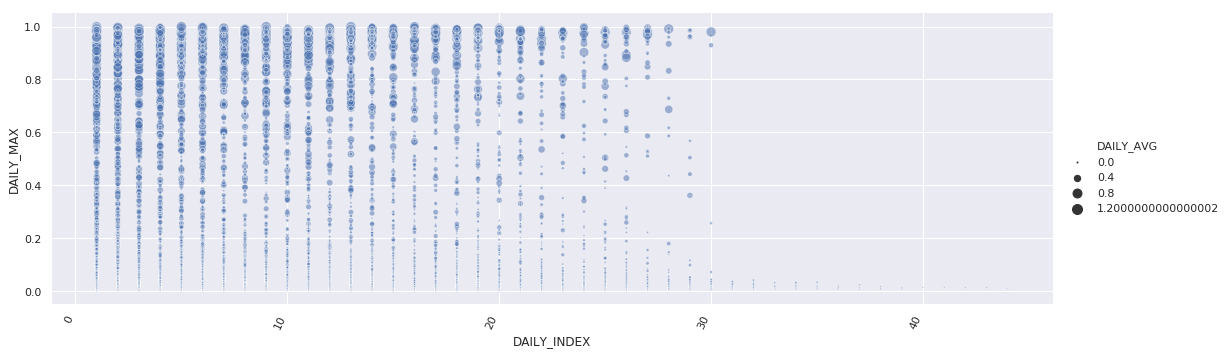

In [27]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
# ax = sns.lineplot(x="DAY_INDEX", y="JCS", hue="CONTENT_ID", data=chartit_pdf)
ax = sns.relplot(x="DAILY_INDEX", y="DAILY_MAX",  size="DAILY_AVG", sizes=(1, 100), alpha=.5, aspect=3,data=chartit_pdf) #hue="CONTENT_ID",
ax.set_xticklabels(rotation=65, horizontalalignment='right');

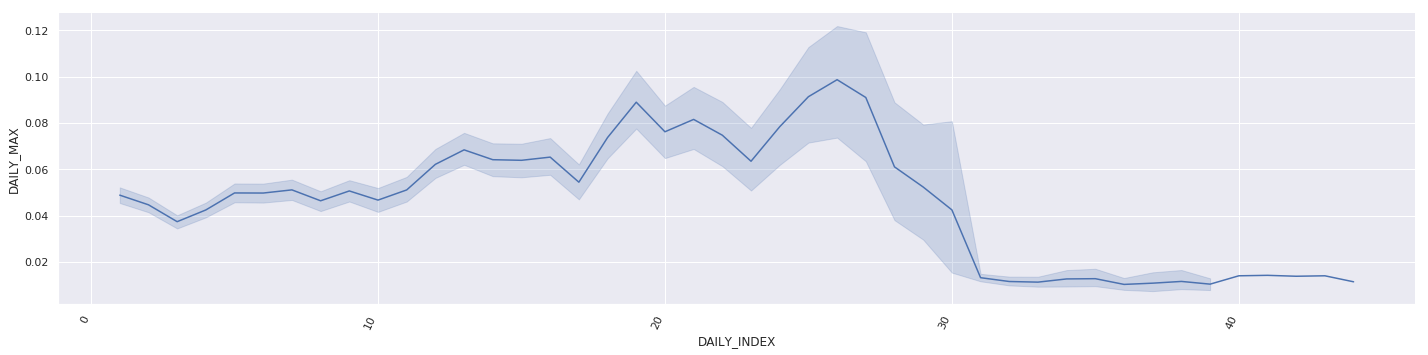

In [28]:
chartit_pdf = daily_grouped_pdf[:]

sns.set(rc={'figure.figsize':(20.7,8.27)})
ax = sns.relplot(x="DAILY_INDEX", y="DAILY_MAX", ci=95, kind="line", aspect=4, data=chartit_pdf);
ax.set_xticklabels(rotation=65, horizontalalignment='right');

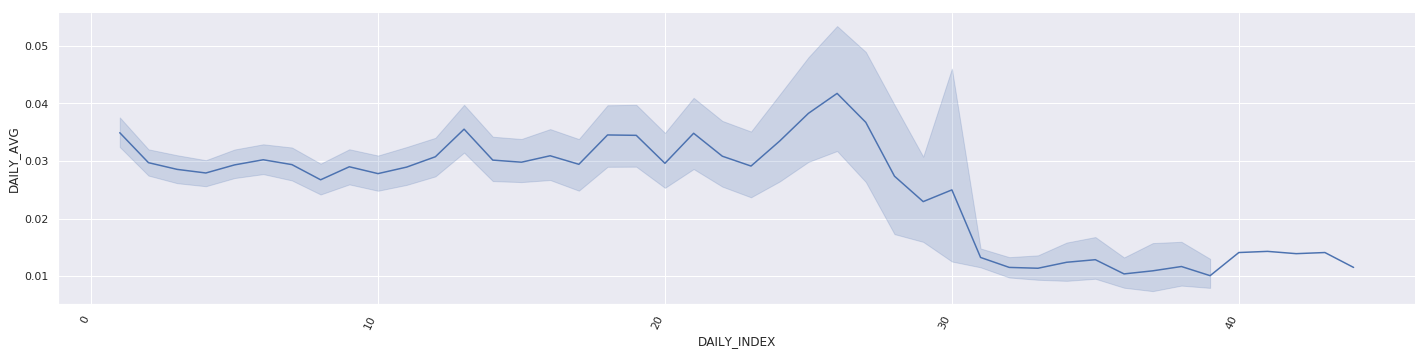

In [29]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
ax = sns.relplot(x="DAILY_INDEX", y="DAILY_AVG", ci=95, kind="line", aspect=4, data=chartit_pdf);
ax.set_xticklabels(rotation=65, horizontalalignment='right');

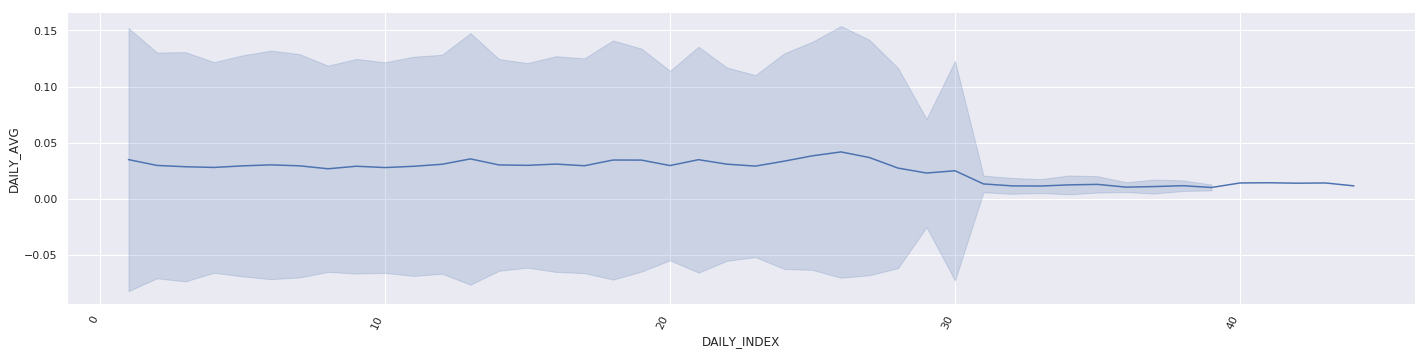

In [30]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
ax = sns.relplot(x="DAILY_INDEX", y="DAILY_AVG", ci="sd", kind="line",aspect=4, data=chartit_pdf);
ax.set_xticklabels(rotation=65, horizontalalignment='right');

## Hypothesis conformation 

### Time-span: March 2020
### With 95% confidence intervel PRs has high impact around 17 days from it's published date.
### With 95% confidence intervel PRs has modetate impact around day 17 to 25 from it's published date.
### JCS over 0.5 is consodered high impact
### JCS ~ 0.4 is consodered moderate impact
